Hello! This is a notebook for forward modeling planetary systems around the disparate K2 stellar samples. The biggest challenge is piece-ing together these K2 fields. We'll be using TRILEGAL to generate stellar populations in these fields. 

K2: https://archive.stsci.edu/missions-and-data/k2/campaign-fields.html#c1 and https://archive.stsci.edu/missions-and-data/k2/documents/data-release-notes

TRILEGAL: https://stev.oapd.inaf.it/cgi-bin/trilegal_1.6 

In [48]:
import os
import os.path
import numpy as np
from numpy import log, exp, pi
import pandas as pd
import scipy
import random
from scipy.stats import gaussian_kde, loguniform, gamma
from math import lgamma
from tqdm import tqdm
from ast import literal_eval
from glob import glob
from tqdm import tqdm
from itertools import zip_longest
import numpy.ma as ma # for masked arrays
from astropy.table import Table, join
import astropy.coordinates as coord
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
from pyia import GaiaData

# these packages are for fitting with numpyro
import numpyro
from numpyro import distributions as dist, infer
import numpyro_ext
import arviz as az
import jax

# these are psps imports
from psps.transit_class import Population, Star
import psps.simulate_helpers as simulate_helpers
import psps.simulate_transit as simulate_transit
import psps.utils as utils

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
matplotlib.rcParams.update({'errorbar.capsize': 1})
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

import warnings
warnings.filterwarnings("ignore")

path = '/Users/chrislam/Desktop/psps/' 

# we're gonna need this for reading in the initial Berger+ 2020 data
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        pass

Berger+23 produced isochrone ages for Kepler/K2/TESS stars. Keep only K2 stars and remove records with uninformative ages (prepended with asterisk).

In [57]:
k2_stars = pd.read_csv(path+'data/k2/k2_stars.csv', sep=',') # originally GKTHCatalog_Table4.txt.csv from Berger+23 (https://arxiv.org/abs/2301.11338), but I just took EPIC IDs
k2_stars['EPIC'] = k2_stars['id_starname'].str.strip('epic').astype(int)
k2_stars = k2_stars[~k2_stars['iso_age'].astype(str).str.startswith('*')]
k2_stars['iso_age'] = k2_stars['iso_age'].astype(float)
k2_stars

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,iso_lum_err1,iso_lum_err2,iso_age,iso_age_err1,iso_age_err2,iso_dis,iso_dis_err1,iso_dis_err2,iso_avs,EPIC
3,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.097678,-0.087197,5.008,2.393,-2.082,462.624807,7.111266,-7.129360,0.000000,201295312
5,epic201384232,5617.490904,104.439531,-112.920238,4.504207,0.031620,-0.054677,-0.067026,0.133046,-0.128326,...,0.025452,-0.024216,3.646,5.272,-2.815,315.819173,4.697152,-4.618715,0.000000,201384232
6,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,0.116242,-0.105389,5.865,2.614,-2.373,687.530006,11.482838,-11.359304,0.192158,201393098
7,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,0.115679,-0.105381,3.633,2.205,-1.778,443.226923,7.071150,-6.956991,0.000000,201403446
9,epic201445732,5855.091952,142.109696,-165.527870,4.370385,0.057779,-0.071913,-0.008679,0.145500,-0.135597,...,0.048757,-0.045087,5.033,4.495,-3.407,311.962902,4.649414,-4.603710,0.000000,201445732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.122407,-0.118200,4.095,2.302,-1.369,455.301611,7.682692,-7.758965,0.000000,211784767
557,epic211914998,5506.434626,100.491856,-107.050256,4.516862,0.029614,-0.053160,-0.003695,0.138075,-0.129787,...,0.023404,-0.022061,3.628,5.515,-2.820,467.044835,7.464813,-7.324307,0.109805,211914998
559,epic211929937,5120.873317,85.776292,-93.976022,4.541658,0.036672,-0.059382,0.092489,0.139585,-0.138446,...,0.015634,-0.014883,6.549,8.667,-5.032,500.969658,9.269712,-9.221000,0.000000,211929937
560,epic211962097,6212.505919,166.837618,-154.772263,3.931147,0.049014,-0.062616,-0.164533,0.138264,-0.129350,...,0.341469,-0.312011,3.474,0.749,-0.759,1381.767640,35.287033,-34.141219,0.000000,211962097


In [58]:
# cross match with ingredients from same paper, to calculate Zmax; originally GKTHCatalog_Table2.txt.csv from Berger+23 (https://arxiv.org/abs/2301.11338), but I just took EPIC IDs
berger23_table2 = pd.read_csv(path+'data/k2/berger23_table2_source_ids.csv')
berger23_table2 = berger23_table2[berger23_table2['id_starname'].str.startswith('epic')]
berger23_table2['EPIC'] = berger23_table2['id_starname'].str.strip('epic').astype(int)

k2_stars = pd.merge(k2_stars, berger23_table2, on=['id_starname', 'EPIC'])
k2_stars

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,bpmag,bpmag_err,rpmag,rpmag_err,parallax,parallax_err,feh,feh_err,feh_prov,ruwe
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,12.336206,0.002874,11.533532,0.003810,2.157181,0.0146,0.146637,0.15,Poly,0.823
1,epic201384232,5617.490904,104.439531,-112.920238,4.504207,0.031620,-0.054677,-0.067026,0.133046,-0.128326,...,12.826021,0.002850,11.992009,0.003801,3.167135,0.0168,0.021680,0.15,Poly,0.929
2,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,13.383867,0.002883,12.542809,0.003794,1.451126,0.0133,-0.220733,0.15,Poly,1.001
3,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,12.159136,0.002849,11.496057,0.003801,2.252150,0.0170,-0.213078,0.15,Poly,0.956
4,epic201445732,5855.091952,142.109696,-165.527870,4.370385,0.057779,-0.071913,-0.008679,0.145500,-0.135597,...,12.193864,0.002862,11.386943,0.003798,3.200969,0.0172,0.001283,0.15,Poly,0.887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,12.113058,0.002838,11.360767,0.003789,2.195042,0.0206,0.050559,0.15,Poly,1.294
338,epic211914998,5506.434626,100.491856,-107.050256,4.516862,0.029614,-0.053160,-0.003695,0.138075,-0.129787,...,13.935163,0.002913,13.020940,0.003828,2.143024,0.0170,0.102435,0.15,Poly,0.976
339,epic211929937,5120.873317,85.776292,-93.976022,4.541658,0.036672,-0.059382,0.092489,0.139585,-0.138446,...,14.598705,0.003176,13.567505,0.003859,1.997430,0.0247,0.153934,0.15,Poly,1.111
340,epic211962097,6212.505919,166.837618,-154.772263,3.931147,0.049014,-0.062616,-0.164533,0.138264,-0.129350,...,13.765182,0.002898,13.070049,0.003862,0.719913,0.0156,-0.194291,0.15,Poly,0.980


In [51]:
# K2 doesn't come with CDPP. Instead, Aigrain+15 report a table of quasi-CDPPs, with the caveat that the durations are going to be different because shorter campaigns mean shorter period planets, which mean shorter : https://academic.oup.com/mnras/article/447/3/2880/2892909

In [52]:
k2_stars.columns

Index(['id_starname', 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'iso_logg',
       'iso_logg_err1', 'iso_logg_err2', 'iso_feh', 'iso_feh_err1',
       'iso_feh_err2', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'iso_age_err1', 'iso_age_err2', 'iso_dis', 'iso_dis_err1',
       'iso_dis_err2', 'iso_avs', 'EPIC', 'dr3_source_id', 'bpmag',
       'bpmag_err', 'rpmag', 'rpmag_err', 'parallax', 'parallax_err', 'feh',
       'feh_err', 'feh_prov', 'ruwe'],
      dtype='object')

#### Bootstrapping and cuts

In [61]:
def draw_asymmetrically(df, mode_name, err1_name, err2_name, drawn):
    """
    Draw stellar properties with asymmetric errors. 
    This is the generalized version of draw_star_ages(), below
    
    Inputs:
    - df: berger_kepler [Pandas DataFrame]
    - mode_name: name of mode column [string]
    - err1_name: name of err1 column [string]
    - err2_name: name of err2 column [string]
    - drawn: name of new column [string]

    Output:
    - df: berger_kepler_df, now with new column with drawn parameter, "drawn" [Pandas DataFrame]
    """

    # in case df is broken up by planet and not star
    uniques = df
    
    if drawn=='age':
        x = np.linspace(0.5, 13.5, 100)
    elif drawn=='gyro_age':
        x = np.linspace(0.5, 4., 100)
    elif drawn=='stellar_radius':
        x = np.linspace(0.5, 5., 100)
    elif drawn=='stellar_mass':
        x = np.linspace(0.5, 2.5, 100)
    elif drawn=='Teff':
        x = np.linspace(3400, 8000, 1000) # x = np.linspace(3700, 7500, 1000); Z23 did (4000, 6500, 1000); originally I did (5300, 7500), but let's just make cuts separately
    elif drawn=='stellar_feh':
        x = np.linspace(-0.5, 0.5, 100)
    elif drawn=='distance':
        x = np.linspace(0, 5000, 1000)
    elif drawn=='planet_radius':
        x = np.linspace(0.5, 10, 100)
    elif drawn=='logg':
        x = np.linspace(3., 5., 1000)  # formerly 3.6 to 4.7 over 100, but there were sampling artifacts due to low resolution and incomplete coverage

    else: 
        print("Please create a column that is either age, gyro_age, stellar_radius, stellar_mass, distance, planet_radius, stellar_feh, or stellar_teff!")

    """
    TESTING
    print("x: ", x)
    pdf = make_pdf_rows(x, mode, err1, err2)
    pdf = pdf/np.sum(pdf)
    draw = np.around(np.random.choice(x, p=pdf), 2)
    print("draw: ", draw)
    """

    if drawn=='planet_radius':
        df_or_uniques = df
    else:
        df_or_uniques = uniques

    draws = np.ones(len(df_or_uniques))
    for i in range(len(df_or_uniques)):
        mode = df_or_uniques.iloc[i][mode_name]
        err1 = df_or_uniques.iloc[i][err1_name]
        err2 = np.abs(df_or_uniques.iloc[i][err2_name])
        
        #"""
        # symmetric uncertainties
        if err1==err2:
            if drawn!='stellar_feh':
                draw = 0
                while draw <= 0: # make sure the draw is positive
                    draw = np.random.normal(mode, err1) # I used to round this to two decimal places but I don't know why I did this.
            elif drawn=='stellar_feh':
                draw = np.random.normal(mode, err1)

        # asymmetric uncertainties
        elif err1!=err2:
            try:
                pdf = make_pdf_rows(x, mode, err1, err2)
                pdf = pdf/np.sum(pdf)
            except Exception as e:
                print(e)
                print(x, mode, err1, err2)

            try:
                if drawn!='stellar_feh':
                    draw = 0
                    while draw <= 0: # make sure the draw is positive
                        draw = np.random.choice(x, p=pdf)
                elif drawn=='stellar_feh':
                    draw = np.random.choice(x, p=pdf)
            except Exception as e:
                #print("EXCEPTION: ", i, pdf, mode, err1, err2)
                #print(e)
                continue
        #"""
        #if draw==1.:
        #    print(draw, mode, err1, err2)
        
        """
        ### make all draws the same way, symmetric or asymmetric
        pdf = make_pdf_rows(x, mode, err1, err2)
        pdf = pdf/np.sum(pdf)

        try:
            draw = 0
            while draw <= 0: # make sure the draw is positive
                draw = np.around(np.random.choice(x, p=pdf), 2)
        except Exception as e:
            print("EXCEPTION: ", i, pdf, mode, err1, err2)
            print(e)
            break
        """

        #print(mode, err1, err2, draw)
        draws[i] = draw

    #print(len(df), len(draws), len(uniques))
    df_or_uniques[drawn] = draws

    # break back out into planet rows and forward fill across systems
    #df = uniques.merge(df, how='right')
    #df[drawn] = df[drawn].fillna(method='ffill')
    
    return df_or_uniques

### adapted from The Cannon project with Aida
def tighter_cull(comparison_df, comparison_teff, comparison_logg):

    comparison_df = comparison_df.loc[((comparison_logg<4.4) & (comparison_teff<6300))]
    comparison_df = comparison_df.loc[((comparison_logg>3.4) & (comparison_teff>5300))]

    return comparison_df

def make_pdf_rows(x, mode, err1, err2):
    """
    Row-wise likelihood of asymmetric uncertainty, using Eqn 6 from https://iopscience.iop.org/article/10.3847/1538-3881/abd93f
    Less efficient, but row-wise in order to troubleshoot. 
    Takes in scalar values for mode, err1, and err2, not arrays.

    Input:
    - x: np.linspace(0.5, 10, 100); just something to undergird the PDF and represent stellar ages
    - mode: mean age; peak of asymmetric PDF
    - err1: + uncertainty
    - err2: - uncertainty (note: must be positive)

    Output:
    - pdf: asymmetric PDF

    """
    
    factor1 = 1/np.sqrt(2*np.pi*err1**2) 
    beta = err1/err2
    gamma = (err1 - np.abs(err2))/(err1 * np.abs(err2))
    
    factor2_arg_a = np.log(1+gamma*(x - mode))
    factor2_arg_b = np.log(beta)
    factor2_arg = factor2_arg_a/factor2_arg_b
    factor2 = np.exp(-0.5*(factor2_arg)**2)

    out = factor1 * factor2
    out[~np.isfinite(out)] = 0.0
    
    return out


#### Calculate Zmax

In [67]:
from astroquery.gaia import Gaia
import pandas as pd

# list of Gaia DR3 source IDs
k2_source_ids = list(k2_stars.dr3_source_id)

# convert to ADQL list
k2_source_list = ",".join(str(s) for s in k2_source_ids)

query = f"""
SELECT source_id,
       ra, dec,
       parallax,
       pmra, pmdec,
       radial_velocity,
	   ra_error, dec_error, parallax_error, pmra_error, pmdec_error, radial_velocity_error
FROM gaiadr3.gaia_source
WHERE source_id IN ({k2_source_list})
"""

job = Gaia.launch_job_async(query)
results = job.get_results()

k2_astrometry = results.to_pandas()
k2_astrometry

INFO: Query finished. [astroquery.utils.tap.core]


,SOURCE_ID,ra,dec,parallax,pmra,pmdec,radial_velocity,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error
0,61624573016925824,52.888851,22.434817,4.615705,-7.942969,-10.844134,0.973049,0.013907,0.010376,0.014570,0.019928,0.014409,1.377523
1,651522834880015872,129.140536,14.461881,13.217502,89.722146,-12.271023,-33.727615,0.015832,0.010264,0.017178,0.018632,0.013662,0.264967
2,655863775507590400,125.223916,16.090791,1.840995,9.805472,-34.567896,-69.233032,0.016108,0.010309,0.018952,0.017103,0.012747,2.652549
3,2599322178998513664,337.044246,-14.599336,4.264093,-3.042030,11.698896,-8.641218,0.017266,0.013766,0.020042,0.020922,0.015885,1.052269
4,2639417798946571648,353.707773,-3.834946,2.732386,21.013893,-8.183468,-47.833054,0.015846,0.013830,0.018649,0.019046,0.016881,2.507941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,4087372834886655104,285.900107,-18.310261,0.801389,-3.021629,-2.410988,3.784722,0.024495,0.024382,0.032710,0.032217,0.021256,1.094914
338,4131047326528868352,249.025160,-19.744525,4.820182,-42.987354,27.625167,-19.482119,0.014415,0.008110,0.016637,0.020089,0.012777,0.913476
339,6260472256256074496,236.840933,-17.610816,1.796603,-5.279529,-1.473174,-23.022844,0.015793,0.011815,0.017826,0.021732,0.014753,1.583088
340,6260956007012322688,237.010174,-16.842446,1.832531,-3.341281,-7.565473,NaN,0.016949,0.012642,0.018962,0.022718,0.015620,NaN


In [68]:
k2_stars = pd.merge(k2_stars, k2_astrometry, left_on='dr3_source_id', right_on='SOURCE_ID')
k2_stars

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,parallax_y,pmra,pmdec,radial_velocity,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,2.121736,6.614481,-12.365250,45.586647,0.014309,0.009947,0.014552,0.023659,0.011433,0.764247
1,epic201384232,5617.490904,104.439531,-112.920238,4.504207,0.031620,-0.054677,-0.067026,0.133046,-0.128326,...,3.140299,-32.251641,7.325712,7.041161,0.012282,0.009171,0.016791,0.017660,0.011535,1.071830
2,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,1.410998,-4.657043,-23.646633,-4.040172,0.012669,0.010187,0.013297,0.015633,0.012143,2.168792
3,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,2.206281,-21.811427,13.824365,18.894762,0.014046,0.011357,0.016955,0.016465,0.012123,1.045084
4,epic201445732,5855.091952,142.109696,-165.527870,4.370385,0.057779,-0.071913,-0.008679,0.145500,-0.135597,...,3.157658,2.811996,-20.806328,-35.101978,0.013434,0.012602,0.017214,0.015770,0.014879,1.030092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,2.147117,6.734759,-16.367881,6.481744,0.017554,0.012035,0.020601,0.019146,0.014207,0.576840
338,epic211914998,5506.434626,100.491856,-107.050256,4.516862,0.029614,-0.053160,-0.003695,0.138075,-0.129787,...,2.099473,-21.047147,-11.894266,33.985680,0.014355,0.006844,0.016967,0.017220,0.011867,1.617407
339,epic211929937,5120.873317,85.776292,-93.976022,4.541658,0.036672,-0.059382,0.092489,0.139585,-0.138446,...,1.954357,-9.471131,-1.815192,1.068546,0.019468,0.013214,0.024675,0.024626,0.017039,4.315491
340,epic211962097,6212.505919,166.837618,-154.772263,3.931147,0.049014,-0.062616,-0.164533,0.138264,-0.129350,...,0.676152,-5.345947,3.467558,32.060375,0.014103,0.008343,0.015626,0.016552,0.012772,6.055880


In [69]:
def gala_galactic_heights_k2(df, output=True):


    """
    Use Gala (Price-Whelan+) to simulate orbits of Gaia stars and get their Z_maxes
    """

    """
    # merge sample with Megan Bedell's Gaia-Kepler cross-match because those save info on RV, proper motion, parallax, etc required for Gala
    berger = Table.read(path+'data/berger_kepler_stellar_fgk.csv')
    megan = Table.read(path+'data/kepler_dr3_good.fits')
    merged = join(berger, megan, keys='kepid')
    merged.rename_column('parallax_2', 'parallax')
    #print(merged[['parallax', 'parallax_error', 'radial_velocity', 'radial_velocity_error']])
    """

    df['radial_velocity'] = np.random.normal(df['radial_velocity'], df['radial_velocity_error'])
    df['pmra'] = np.random.normal(df['pmra'], df['pmra_error'])
    df['pmdec'] = np.random.normal(df['pmdec'], df['pmdec_error'])
    df['parallax'] = np.random.normal(df['parallax'], df['parallax_err'])

    # mise en place
    with coord.galactocentric_frame_defaults.set("v4.0"):
        galcen_frame = coord.Galactocentric()

    sun_xyz = u.Quantity(
        [-galcen_frame.galcen_distance, 0 * u.kpc, galcen_frame.z_sun]  # x  # y  # z
    )

    sun_w0 = gd.PhaseSpacePosition(pos=sun_xyz, vel=galcen_frame.galcen_v_sun)

    mw_potential = gp.MilkyWayPotential()

    sun_orbit = mw_potential.integrate_orbit(sun_w0, dt=0.5 * u.Myr, t1=0, t2=4 * u.Gyr)

    star_gaia = GaiaData(df)

    star_gaia_c = star_gaia.get_skycoord()
    star_galcen = star_gaia_c.transform_to(galcen_frame)
    star_w0 = gd.PhaseSpacePosition(star_galcen.data)

    # calculate orbits and retrieve Z_maxes
    zmaxes = []
    for i in tqdm(range(len(star_gaia))):
    #for i in range(1000):
        star_orbit = mw_potential.integrate_orbit(star_w0[i], t=sun_orbit.t) 
        zmax = star_orbit.zmax().value
        zmaxes.append(zmax)

    zmaxes_df = pd.DataFrame({'height': zmaxes})
    #zmaxes_df.to_csv(path+'data/zmaxes.csv', index=False)
    
    return zmaxes

In [73]:
k2_stars['parallax'] = k2_stars['parallax_x']
k2_stars['height'] = gala_galactic_heights_k2(Table.from_pandas(k2_stars))

100%|██████████| 342/342 [00:02<00:00, 163.66it/s]


In [87]:
# fractional age cuts
k2_stars['fractional_err1'] = k2_stars.iso_age_err1/k2_stars.iso_age
k2_stars['fractional_err2'] = k2_stars.iso_age_err2/k2_stars.iso_age
print(np.nanmedian(k2_stars.iso_age_err1/k2_stars.iso_age))
print(np.nanmedian(k2_stars.iso_age_err2/k2_stars.iso_age))
k2_stars_age = k2_stars.loc[(k2_stars.fractional_err1 <= 1.15) & (np.abs(k2_stars.fractional_err2) <= 0.74)] # 0.5 and 0.4, vs 1.15 and 0.74
print("age uncertainty cut: ", len(k2_stars_age))

# remove stars without full astrometric solution
# never mind, later on I can use Astroquery to get them for all 342 stars

k2_stars_bootstrapped = pd.DataFrame()
len_teff_cut = []
len_giant_cut = []
len_logg_cut = []
len_metal_cut = []
len_age_cut = []
for i in tqdm(range(10)):

	k2_stars_temp = draw_asymmetrically(k2_stars_age, 'iso_age', 'iso_age_err1', 'iso_age_err2', 'age')
	k2_stars_temp = draw_asymmetrically(k2_stars_temp, 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'Teff')
	k2_stars_temp = draw_asymmetrically(k2_stars_temp, 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'logg')
	k2_stars_temp = draw_asymmetrically(k2_stars_temp, 'iso_rad', 'iso_rad_err1', 'iso_rad_err2', 'stellar_radius')
	k2_stars_temp = draw_asymmetrically(k2_stars_temp, 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'stellar_feh')

	# remove stars beyond [3900, 7500] K Teff, ie. keep only FGK stars
	k2_stars_temp = k2_stars_temp.loc[(k2_stars_temp['Teff'] <= 7500) & (k2_stars_temp['Teff'] >= 3900)]
	#print("teff cut: ", len(kepler_stars_temp))
	len_teff_cut.append(len(k2_stars_temp))

	# isolate giant stars
	# using unnumbered equation in first paragraph of Sec 4.2.1 ("Sample Selection") in Berger et al 2020b 
	k2_stars_temp['logR'] = np.log10(k2_stars_temp.stellar_radius)
	k2_stars_temp['is_giant'] = np.where(k2_stars_temp['logR'] >= 0.00035*(k2_stars_temp['Teff'] - 4500) + 0.15, True, False)
	k2_stars_temp = k2_stars_temp.loc[k2_stars_temp['is_giant'] == False]
	#print("giant cut: ", len(kepler_stars_temp))
	len_giant_cut.append(len(k2_stars_temp))

	# remove poofy stars that the giant cut didn't remove
	k2_stars_temp = k2_stars_temp.loc[(k2_stars_temp['logg']<4.7)& (k2_stars_temp['logg']>4.)]
	len_logg_cut.append(len(k2_stars_temp))

	# remove stars outside of Solar metallicity +/- 0.25 dex
	k2_stars_temp = k2_stars_temp.loc[(k2_stars_temp['feh']<=0.25) & (k2_stars_temp['feh']>=-0.25)]
	len_metal_cut.append(len(k2_stars_temp))

	# remove stars older than 12 Gyr
	k2_stars_temp = k2_stars_temp.loc[k2_stars_temp['age']<=12.]
	len_age_cut.append(len(k2_stars_temp))
	
	k2_stars_bootstrapped = pd.concat([k2_stars_bootstrapped, k2_stars_temp])

print("teff cut: ", np.mean(len_teff_cut), np.std(len_teff_cut))
print("giant cut: ", np.mean(len_giant_cut), np.std(len_giant_cut))
print("logg cut: ", np.mean(len_logg_cut), np.std(len_logg_cut))
print("metal cut: ", np.mean(len_metal_cut), np.std(len_metal_cut))
print("age cut: ", np.mean(len_age_cut), np.std(len_age_cut))

print(len(k2_stars_bootstrapped))



1.1535363443582716
-0.7357143284466074
age uncertainty cut:  166


100%|██████████| 10/10 [00:01<00:00,  8.83it/s]

teff cut:  164.1 0.7000000000000001
giant cut:  162.4 1.7435595774162693
logg cut:  136.9 2.118962010041709
metal cut:  102.9 1.445683229480096
age cut:  98.2 2.2271057451320084
982


0       6.277778
2       9.429293
3       2.207071
13      7.722222
22      7.328283
         ...    
322    11.398990
326    10.742424
334     8.772727
335     3.388889
337     3.782828
Name: age, Length: 982, dtype: float64
0      792.690697
2      838.486699
3      615.330049
13      49.705359
22     305.164506
          ...    
322    331.404007
326    426.451687
334    692.183209
335    665.649320
337    282.480876
Name: height, Length: 982, dtype: float64


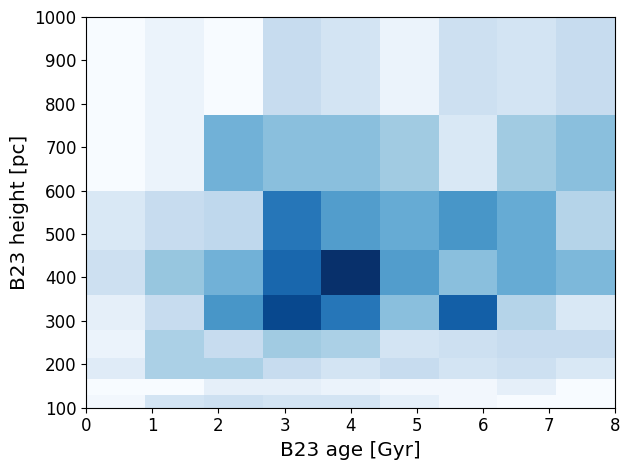

In [97]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='B23'
ages = k2_stars_bootstrapped['age']
heights = k2_stars_bootstrapped['height']*1000
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B23':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B23 age [Gyr]')
	plt.ylabel('B23 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_B23_bootstrapped.png')
plt.show()

#### Kiel diagram

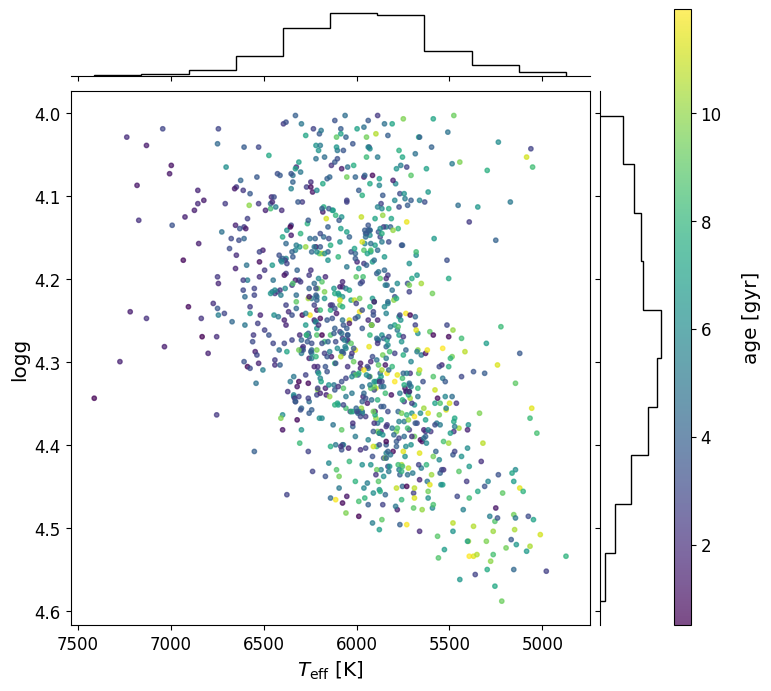

In [92]:
from matplotlib.gridspec import GridSpec

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 3, figure=fig, wspace=0.05, hspace=0.05, width_ratios=[8, 1, 0.25], height_ratios=[1, 8]) # two horizontal assets, but third vertical asset required for colorbar

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1, 0])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.00, pos.width, pos.height])
ax_histx.set_yticks([])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
ax_histy.set_xticks([])

im = ax_scatter.scatter(k2_stars_bootstrapped['Teff'], k2_stars_bootstrapped['logg'], s=10, alpha=0.7, c=k2_stars_bootstrapped['age'])

# histograms
ax_histx.hist(k2_stars_bootstrapped['Teff'], bins=10, histtype='step', color="k", linewidth=1)
ax_histy.hist(k2_stars_bootstrapped['logg'], bins=10, orientation='horizontal', histtype='step', color="k", linewidth=1)
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
#ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

# add colorbar as final asset
ax_cbar = fig.add_subplot(gs[:, 2])

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K]")
ax_scatter.set_ylabel('logg')
#plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
#ax_scatter.set_xlim([7600, 3900])
#ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label='age [Gyr]')
cbar = fig.colorbar(im, cax=ax_cbar)
cbar.set_label('age [gyr]', labelpad=15)
cbar.ax.yaxis.set_label_position("right")
plt.tight_layout()
plt.savefig(path+'plots/k2/kiel_b23_k2.png')
plt.show()

B23 didn't have kepmag. So I went to Exoplanet Archive's Table Access Protocol (TAP; https://exoplanetarchive.ipac.caltech.edu/docs/program_interfaces.html#k2) and queried all K2 targets there. Don't say I didn't do nothin

In [102]:
k2candidates = pd.read_csv(path+'data/k2/k2candidates.csv', sep=',')

In [103]:
k2candidates.head()

,epic_number,tm_name,k2_campaign_str,k2_type,rastr,decstr,k2_propid,k2_dist,k2_disterr1,k2_disterr2,...,k2_mass,k2_masserr1,k2_masserr2,k2_kepmag,k2_kepmagerr,k2_kepmagflag,k2_vjmag,k2_vjmagerr,k2_kmag,k2_kmagerr
0,60018365,2MASS J23391492-0556597,E,NaN,23h39m14.93s,-05d56m59.7s,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.12,NaN,NaN,NaN,NaN,8.751,0.019
1,60018369,2MASS J23550014-0224072,E,NaN,23h55m00.15s,-02d24m07.1s,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.14,NaN,NaN,NaN,NaN,8.975,0.021
2,60018371,2MASS J23572163+0041200,E,NaN,23h57m21.64s,+00d41m19.9s,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.14,NaN,NaN,NaN,NaN,8.632,0.027
3,60018372,2MASS J23392604-0328341,E,NaN,23h39m26.04s,-03d28m34.0s,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.15,NaN,NaN,NaN,NaN,8.955,0.023
4,60018374,2MASS J00035057+0046323,E,NaN,00h03m50.59s,+00d46m32.4s,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10.15,NaN,NaN,NaN,NaN,8.928,0.023


In [126]:
k2_stars_candidates = pd.merge(k2_stars_bootstrapped, k2candidates[['epic_number','k2_kmag','k2_kmagerr']], left_on='EPIC', right_on='epic_number', how='inner')

In [125]:
k2_stars_candidates

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,pmdec_error,radial_velocity_error,parallax,zmax,height,logR,is_giant,epic_number,k2_kmag,k2_kmagerr
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.011433,0.764247,2.157181,0.810513,0.792691,0.176091,False,201295312,10.693,0.024
1,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,0.012143,2.168792,1.451126,0.815855,0.838487,0.134699,False,201393098,11.564,0.021
2,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,0.012123,1.045084,2.252150,0.602279,0.615330,0.088941,False,201403446,10.781,0.024
3,epic203859264,6233.420322,195.948088,-162.996775,4.203730,0.061826,-0.061202,0.023804,0.143255,-0.149956,...,0.057393,1.854031,9.695823,0.046708,0.049705,0.134699,False,203859264,7.425,0.029
4,epic205943325,6278.710495,186.982554,-158.075486,4.126323,0.056826,-0.061891,-0.155873,0.139901,-0.147015,...,0.020774,0.641168,2.578636,0.305694,0.305165,0.201645,False,205943325,10.063,0.025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160,epic211321953,5663.408682,120.867182,-140.808798,4.436160,0.049323,-0.072159,0.034140,0.143575,-0.134512,...,0.016525,2.847138,1.611941,0.481412,0.426452,0.000000,False,211321953,12.222,0.024
1161,epic211679060,5773.445636,134.640506,-148.881062,4.418212,0.055653,-0.075431,-0.101818,0.134694,-0.135504,...,0.014901,3.504841,1.596918,0.663779,0.692183,0.019305,False,211679060,12.188,0.021
1162,epic211724246,6068.102400,161.327880,-148.201749,3.947830,0.050000,-0.053474,0.069258,0.159525,-0.112089,...,0.011448,2.275411,0.867019,0.696787,0.665649,0.310790,False,211724246,11.906,0.024
1163,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.014207,0.576840,2.195042,0.286814,0.282481,0.201645,False,211784767,10.560,0.019


In [127]:
k2_stars_bootstrapped

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error,parallax,zmax,height,logR,is_giant
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.009947,0.014552,0.023659,0.011433,0.764247,2.157181,0.810513,0.792691,0.176091,False
2,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,0.010187,0.013297,0.015633,0.012143,2.168792,1.451126,0.815855,0.838487,0.134699,False
3,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,0.011357,0.016955,0.016465,0.012123,1.045084,2.252150,0.602279,0.615330,0.088941,False
13,epic203859264,6233.420322,195.948088,-162.996775,4.203730,0.061826,-0.061202,0.023804,0.143255,-0.149956,...,0.031513,0.070091,0.082194,0.057393,1.854031,9.695823,0.046708,0.049705,0.134699,False
22,epic205943325,6278.710495,186.982554,-158.075486,4.126323,0.056826,-0.061891,-0.155873,0.139901,-0.147015,...,0.018374,0.025915,0.024564,0.020774,0.641168,2.578636,0.305694,0.305165,0.201645,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,epic251554286,5602.401319,135.560067,-149.234479,4.446355,0.061200,-0.077488,-0.141541,0.132371,-0.132762,...,0.009252,0.018018,0.020173,0.010145,0.504948,3.744176,0.328771,0.331404,-0.041393,False
326,epic211321953,5663.408682,120.867182,-140.808798,4.436160,0.049323,-0.072159,0.034140,0.143575,-0.134512,...,0.011598,0.019787,0.020399,0.016525,2.847138,1.611941,0.481412,0.426452,0.000000,False
334,epic211679060,5773.445636,134.640506,-148.881062,4.418212,0.055653,-0.075431,-0.101818,0.134694,-0.135504,...,0.010177,0.018941,0.019808,0.014901,3.504841,1.596918,0.663779,0.692183,0.019305,False
335,epic211724246,6068.102400,161.327880,-148.201749,3.947830,0.050000,-0.053474,0.069258,0.159525,-0.112089,...,0.006988,0.015798,0.016052,0.011448,2.275411,0.867019,0.696787,0.665649,0.310790,False


### Skip to 3D Positions section below

In [6]:
# oh cool the Scaling K2 pt 2 paper has CDPPs! Zink+20: https://iopscience.iop.org/article/10.3847/1538-3881/ab7448#ajab7448t3
k2_cdpps = pd.read_csv(path+'data/k2/scaling_k2_pt2_table1_cdpp.txt',sep='\s+')
print(k2_cdpps)
#k2_stars = pd.merge(k2_stars, k2_cdpps[['EPIC', 'CDPP60']], on='EPIC')
#print(k2_stars)

            EPIC    CDPP10    CDPP15    CDPP20    CDPP25    CDPP30    CDPP40  \
0      211757991   144.911   136.083   121.719   113.490   109.661    98.879   
1      212029436  1584.883  1467.489  1497.115  1371.193  1308.514  1191.682   
2      211682710   108.918    89.812    82.123    69.502    64.331    58.029   
3      211429539  1281.174  1020.636   917.835   835.924   780.876   687.515   
4      211828625   360.837   291.578   259.953   227.798   210.414   183.354   
...          ...       ...       ...       ...       ...       ...       ...   
25026  211802909   432.860   386.795   387.898   364.690   325.346   326.565   
25027  211490307  1292.834  1309.788  1254.581  1465.099  1199.701  1210.272   
25028  211409713   847.386   812.311   748.193   760.363   766.329   758.434   
25029  211566738   360.844   320.730   266.292   268.193   251.256   207.198   
25030  212163345   679.142   633.067   530.748   456.516   447.219   389.510   

         CDPP50    CDPP60    CDPP70    

In [7]:
k2_stars.columns

Index(['id_starname', 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'iso_logg',
       'iso_logg_err1', 'iso_logg_err2', 'iso_feh', 'iso_feh_err1',
       'iso_feh_err2', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'iso_age_err1', 'iso_age_err2', 'iso_dis', 'iso_dis_err1',
       'iso_dis_err2', 'iso_avs', 'EPIC', 'dr3_source_id', 'bpmag',
       'bpmag_err', 'rpmag', 'rpmag_err', 'parallax', 'parallax_err', 'feh',
       'feh_err', 'feh_prov', 'ruwe'],
      dtype='object')

In [8]:
k2_planets = pd.read_csv(path+'data/k2/k2_planets.csv', sep=',') # originally GKTHCatalog_Table5.txt.csv from Berger+23 (https://arxiv.org/abs/2301.11338), but I just took EPIC IDs
k2_planets

,id_starname,id_planet,disposition,orbper,orbper_err1,orbper_err2,rprstar,rprstar_err1,rprstar_err2,prad,prad_err1,prad_err2,sma,sma_err1,sma_err2,insol,insol_err1,insol_err2
0,epic201155177,epic201155177.01,KP,6.689040,0.000796,-0.000871,0.0285,0.001,-0.001,2.152833,0.094962,-0.100569,0.061054,0.001093,-0.001234,49.116873,3.183305,-4.934830
1,epic201208431,epic201208431.01,KP,10.004208,0.000881,-0.000858,0.0352,0.001,-0.001,2.474641,0.091672,-0.088239,0.077375,0.000856,-0.000860,17.274730,1.036056,-0.856952
2,epic201247497,epic201247497.01,PC,2.754012,0.000122,-0.000132,0.0917,0.028,-0.019,6.823819,2.094023,-1.432153,0.033392,0.000402,-0.000663,116.013351,15.739793,-14.915886
3,epic201295312,epic201295312.01,KP,5.656766,0.000276,-0.000323,0.0171,0.000,-0.000,2.731644,0.138787,-0.129256,0.065229,0.001604,-0.001460,567.311866,36.131216,-32.633066
4,epic201338508,epic201338508.01,KP,10.934881,0.000982,-0.001177,0.0315,0.002,-0.001,2.019263,0.139334,-0.084410,0.079864,0.000936,-0.000505,11.831787,0.552315,-0.462909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,epic211962097,epic211962097.01,LPPC,5.839233,0.000095,-0.000112,0.0947,0.000,-0.001,20.977987,1.001641,-0.982876,0.069063,0.001733,-0.001778,1172.787800,92.683066,-89.019938
672,epic211990866,epic211990866.01,KP,1.673847,0.000040,-0.000042,0.0296,0.001,-0.001,3.741022,0.194765,-0.167309,0.028937,0.000338,-0.000665,1909.568588,85.525794,-111.179584
673,epic212009150,epic212009150.01,PC,6.832256,0.000644,-0.000750,0.0602,0.005,-0.005,1.548175,0.150864,-0.148084,0.041852,0.000629,-0.000685,3.214271,0.200392,-0.169147
674,epic212035441,epic212035441.01,PC,2.714743,0.000277,-0.000276,0.0264,0.001,-0.001,1.144098,0.066527,-0.065158,0.027550,0.000230,-0.000487,23.633212,2.182990,-1.923210


In [9]:
list(k2_planets.columns)

['id_starname',
 'id_planet',
 'disposition',
 'orbper',
 'orbper_err1',
 'orbper_err2',
 'rprstar',
 'rprstar_err1',
 'rprstar_err2',
 'prad',
 'prad_err1',
 'prad_err2',
 'sma',
 'sma_err1',
 'sma_err2',
 'insol',
 'insol_err1',
 'insol_err2']

### TRILEGAL (from Sarah)

These are TESS TRILEGAL query results, using the same search parameters from Muirhead+18: https://iopscience.iop.org/article/10.3847/1538-3881/aab710

In [20]:
from astropy.io import fits

In [ ]:
# K2 campaign pointings, from https://archive.stsci.edu/missions-and-data/k2/campaign-fields
ras = [173.939610, 246.1264, 336.66534641439, 59.0759116, 130.1576478, 204.8650344, 287.82850661, 16.3379975, 270.3544823, 186.7794430,
	   260.3880064, 351.6588124, 72.7971166, 160.6824762, 233.6175730, 133.7099689, 202.5496152, 
	   130.1610170, 347.2590265]
decs = [1.4172989, -22.4473, -11.096663792177, 18.6605794, 16.8296140, -11.2953585, -23.36001815, 5.2623459, -21.7798098, -4.0271572,
		-23.9759578, -5.1023328, 20.7870759, 6.8509316, -20.0792397, 18.5253931, -7.7210759, 
		16.8278629, -4.2027029]
campaigns = np.arange(19)+1
highs = [1, 3, 6, 8, 10, 12, 14, 17, 19]
lows = [2, 4, 5, 7, 9, 11, 13, 15, 16, 18]
k2_pointings = dict({'campaign': campaigns, 'ra': ras, 'dec': decs})
print(k2_pointings)


{'campaign': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]), 'ra': [173.93961, 246.1264, 336.66534641439, 59.0759116, 130.1576478, 204.8650344, 287.82850661, 16.3379975, 270.3544823, 186.779443, 260.3880064, 351.6588124, 72.7971166, 160.6824762, 233.617573, 133.7099689, 202.5496152, 130.161017, 347.2590265], 'dec': [1.4172989, -22.4473, -11.096663792177, 18.6605794, 16.829614, -11.2953585, -23.36001815, 5.2623459, -21.7798098, -4.0271572, -23.9759578, -5.1023328, 20.7870759, 6.8509316, -20.0792397, 18.5253931, -7.7210759, 16.8278629, -4.2027029]}


In [14]:
tri1 = path+'data/k2/sarah_trilegal/trilegal_0_499.fits'
hdul1 = fits.open(tri1)    
hdul1[1].header

XTENSION= 'BINTABLE'           /Binary table written by MWRFITS v1.6a           
BITPIX  =                    8 /Required value                                  
NAXIS   =                    2 /Required value                                  
NAXIS1  =                  254 /Number of bytes per row                         
NAXIS2  =               738179 /Number of rows                                  
PCOUNT  =                    0 /Normally 0 (no varying arrays)                  
GCOUNT  =                    1 /Required value                                  
TFIELDS =                   28 /Number of columns in table                      
COMMENT                                                                         
COMMENT  *** End of mandatory fields ***                                        
COMMENT                                                                         
COMMENT                                                                         
COMMENT  *** Column names **

### Start here for my own TRILEGAL run! 

#### kepmag to cdpp

In [93]:
def kepmag_to_cdpp_vectorized(data1, data2):

    """
    Use Kepler mag vs CDPP (6 hr) relation from Berger Kepler-Gaia crossmatch to infer CDPP given simulated kepmag from TRILEGAL, etc
    Fold in Teff and galactic height, since these bear indirectly on noise properties and directly on experimental dependent variables
    Inputs:
    - data1: reference DataFrame, with Kepler mag and CDPP
    - data2: target DataFrame from which to sample

    Output:
    #- cdpps: new array of CDPPs
    - new_data2: this operation culls records that have NaN heights, etc. So let's use this opportunity to cull the entire DF, rather than output a column of different length from the original
    """

    cols_to_match = ['mag_bins', 'teff_bins', 'logg_bins']
    logg_bins = np.linspace(3.0, 4.6, 5) 
    teff_bins = np.linspace(5300, 7500, 50) # (5300, 7500, 50) or (4000, 6500, 50)
    mag_bins = np.linspace(8, 16, 5)
    age_bins = np.linspace(0, 14, 10) # (0, 14, 10) or (0, 8, 10)
    stellar_radius_bins = np.linspace(1, 3.5, 5)
    cdpp_bins = np.linspace(0, 1000, 10) # (0, 100, 10)
    height_bins = np.logspace(2,3,6)
    
    # reference DataFrame
    data1['mag_bins'] = pd.cut(data1['kepmag'], bins=mag_bins, include_lowest=True)
    data1['logg_bins'] = pd.cut(data1['iso_logg'], bins=logg_bins, include_lowest=True)
    data1['teff_bins'] = pd.cut(data1['iso_teff'], bins=teff_bins, include_lowest=True)
    #data1['stellar_radius_bins'] = pd.cut(data1['iso_rad'], bins=stellar_radius_bins, include_lowest=True)
    #data1['cdpp_bins'] = pd.cut(data1['rrmscdpp06p0'], bins=cdpp_bins, include_lowest=True)
    #data1['height_bins'] = pd.cut(data1['height'], bins=height_bins, include_lowest=True)
    #data1['age_bins'] = pd.cut(data1['age'], bins=age_bins, include_lowest=True)

    data1_cdpp_mean = data1.groupby(cols_to_match)['rrmscdpp06p0'].mean().reset_index()
    data1_cdpp_mean = data1_cdpp_mean.pivot(index='mag_bins', columns=cols_to_match[1:])

    data1_cdpp_std = data1.groupby(cols_to_match)['rrmscdpp06p0'].std().reset_index()
    data1_cdpp_std = data1_cdpp_std.pivot(index='mag_bins', columns=cols_to_match[1:])

    # unstack pivot tables
    data1_unstacked_mean = data1_cdpp_mean.unstack().reset_index()
    data1_unstacked_mean = data1_unstacked_mean[['mag_bins', 'teff_bins', 'logg_bins', 0]]
    data1_unstacked_mean.columns = ['mag_bins', 'teff_bins', 'logg_bins','cdpp_mean']
    data1_unstacked_mean.dropna(subset=['cdpp_mean'], inplace=True)
    #print(data1_unstacked_mean)

    data1_unstacked_std = data1_cdpp_std.unstack().reset_index()
    data1_unstacked_std = data1_unstacked_std[['mag_bins', 'teff_bins', 'logg_bins', 0]]
    data1_unstacked_std.columns = ['mag_bins', 'teff_bins', 'logg_bins','cdpp_std']
    data1_unstacked_std.dropna(subset=['cdpp_std'], inplace=True)
    #print(data1_unstacked_std)

    # target DataFrame from which to sample
    data2['mag_bins'] = pd.cut(data2['Kepler'], bins=mag_bins, include_lowest=True)
    data2['logg_bins'] = pd.cut(data2['logg'], bins=logg_bins, include_lowest=True)
    data2['teff_bins'] = pd.cut(data2['Teff'], bins=teff_bins, include_lowest=True)
    #data2['stellar_radius_bins'] = pd.cut(data2['stellar_radius'], bins=stellar_radius_bins, include_lowest=True)
    #data2['cdpp_bins'] = pd.cut(data2['cdpp'], bins=cdpp_bins, include_lowest=True)
    #data2['height_bins'] = pd.cut(data2['height'], bins=height_bins, include_lowest=True)
    #data2['age_bins'] = pd.cut(data2['age'], bins=age_bins, include_lowest=True)
    #print(data2)

    # merge the DataFrames on the multiple columns
    new_data2 = pd.merge(data2, data1_unstacked_mean, on=cols_to_match, how='inner')
    new_data2.dropna(subset=['cdpp_mean'], inplace=True)

    new_data2 = pd.merge(new_data2, data1_unstacked_std, on=cols_to_match, how='inner')
    new_data2.dropna(subset=['cdpp_std'], inplace=True)
    #print(new_data2)

    # sample from target
    new_data2['cdpp'] = np.random.normal(new_data2['cdpp_mean'], new_data2['cdpp_std'])

    return new_data2

#### calculate Zmax

In [10]:
from astroquery.gaia import Gaia
import pandas as pd

# list of Gaia DR3 source IDs
k2_source_ids = list(k2_stars.dr3_source_id)

# convert to ADQL list
k2_source_list = ",".join(str(s) for s in k2_source_ids)

query = f"""
SELECT source_id,
       ra, dec,
       parallax,
       pmra, pmdec,
       radial_velocity,
	   ra_error, dec_error, parallax_error, pmra_error, pmdec_error, radial_velocity_error
FROM gaiadr3.gaia_source
WHERE source_id IN ({k2_source_list})
"""

job = Gaia.launch_job_async(query)
results = job.get_results()

k2_astrometry = results.to_pandas()
k2_astrometry

INFO: Query finished. [astroquery.utils.tap.core]


,SOURCE_ID,ra,dec,parallax,pmra,pmdec,radial_velocity,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error
0,61624573016925824,52.888851,22.434817,4.615705,-7.942969,-10.844134,0.973049,0.013907,0.010376,0.014570,0.019928,0.014409,1.377523
1,651522834880015872,129.140536,14.461881,13.217502,89.722146,-12.271023,-33.727615,0.015832,0.010264,0.017178,0.018632,0.013662,0.264967
2,655863775507590400,125.223916,16.090791,1.840995,9.805472,-34.567896,-69.233032,0.016108,0.010309,0.018952,0.017103,0.012747,2.652549
3,2599322178998513664,337.044246,-14.599336,4.264093,-3.042030,11.698896,-8.641218,0.017266,0.013766,0.020042,0.020922,0.015885,1.052269
4,2639417798946571648,353.707773,-3.834946,2.732386,21.013893,-8.183468,-47.833054,0.015846,0.013830,0.018649,0.019046,0.016881,2.507941
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,3809028584392561408,161.734971,1.936704,1.642409,-22.995652,0.088336,7.949187,0.017844,0.014812,0.019713,0.022812,0.018229,2.572012
338,3873720343877537280,153.655255,6.612164,4.900701,-58.192073,-82.182259,52.403484,0.017203,0.013888,0.017869,0.022912,0.017205,0.213378
339,4073845955650351488,283.370909,-25.954197,1.616854,-1.019818,-10.437214,-25.518486,0.014342,0.012812,0.014661,0.018614,0.015046,8.036389
340,4083159643769233408,290.810172,-20.166378,1.485067,8.658432,-7.006458,-9.651388,0.012148,0.011292,0.013362,0.014320,0.013201,1.955143


In [11]:
k2_stars = pd.merge(k2_stars, k2_astrometry, left_on='dr3_source_id', right_on='SOURCE_ID')
k2_stars

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,parallax_y,pmra,pmdec,radial_velocity,ra_error,dec_error,parallax_error,pmra_error,pmdec_error,radial_velocity_error
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,2.121736,6.614481,-12.365250,45.586647,0.014309,0.009947,0.014552,0.023659,0.011433,0.764247
1,epic201384232,5617.490904,104.439531,-112.920238,4.504207,0.031620,-0.054677,-0.067026,0.133046,-0.128326,...,3.140299,-32.251641,7.325712,7.041161,0.012282,0.009171,0.016791,0.017660,0.011535,1.071830
2,epic201393098,6083.267390,190.449673,-194.152360,4.167140,0.068677,-0.077967,-0.183879,0.134894,-0.161991,...,1.410998,-4.657043,-23.646633,-4.040172,0.012669,0.010187,0.013297,0.015633,0.012143,2.168792
3,epic201403446,6292.483390,184.963741,-177.941360,4.242795,0.060327,-0.064497,-0.198927,0.130812,-0.149465,...,2.206281,-21.811427,13.824365,18.894762,0.014046,0.011357,0.016955,0.016465,0.012123,1.045084
4,epic201445732,5855.091952,142.109696,-165.527870,4.370385,0.057779,-0.071913,-0.008679,0.145500,-0.135597,...,3.157658,2.811996,-20.806328,-35.101978,0.013434,0.012602,0.017214,0.015770,0.014879,1.030092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,2.147117,6.734759,-16.367881,6.481744,0.017554,0.012035,0.020601,0.019146,0.014207,0.576840
338,epic211914998,5506.434626,100.491856,-107.050256,4.516862,0.029614,-0.053160,-0.003695,0.138075,-0.129787,...,2.099473,-21.047147,-11.894266,33.985680,0.014355,0.006844,0.016967,0.017220,0.011867,1.617407
339,epic211929937,5120.873317,85.776292,-93.976022,4.541658,0.036672,-0.059382,0.092489,0.139585,-0.138446,...,1.954357,-9.471131,-1.815192,1.068546,0.019468,0.013214,0.024675,0.024626,0.017039,4.315491
340,epic211962097,6212.505919,166.837618,-154.772263,3.931147,0.049014,-0.062616,-0.164533,0.138264,-0.129350,...,0.676152,-5.345947,3.467558,32.060375,0.014103,0.008343,0.015626,0.016552,0.012772,6.055880


In [12]:
def gala_galactic_heights_k2(df, output=True):


    """
    Use Gala (Price-Whelan+) to simulate orbits of Gaia stars and get their Z_maxes
    """

    """
    # merge sample with Megan Bedell's Gaia-Kepler cross-match because those save info on RV, proper motion, parallax, etc required for Gala
    berger = Table.read(path+'data/berger_kepler_stellar_fgk.csv')
    megan = Table.read(path+'data/kepler_dr3_good.fits')
    merged = join(berger, megan, keys='kepid')
    merged.rename_column('parallax_2', 'parallax')
    #print(merged[['parallax', 'parallax_error', 'radial_velocity', 'radial_velocity_error']])
    """

    df['radial_velocity'] = np.random.normal(df['radial_velocity'], df['radial_velocity_error'])
    df['pmra'] = np.random.normal(df['pmra'], df['pmra_error'])
    df['pmdec'] = np.random.normal(df['pmdec'], df['pmdec_error'])
    df['parallax'] = np.random.normal(df['parallax'], df['parallax_err'])

    # mise en place
    with coord.galactocentric_frame_defaults.set("v4.0"):
        galcen_frame = coord.Galactocentric()

    sun_xyz = u.Quantity(
        [-galcen_frame.galcen_distance, 0 * u.kpc, galcen_frame.z_sun]  # x  # y  # z
    )

    sun_w0 = gd.PhaseSpacePosition(pos=sun_xyz, vel=galcen_frame.galcen_v_sun)

    mw_potential = gp.MilkyWayPotential()

    sun_orbit = mw_potential.integrate_orbit(sun_w0, dt=0.5 * u.Myr, t1=0, t2=4 * u.Gyr)

    star_gaia = GaiaData(df)

    star_gaia_c = star_gaia.get_skycoord()
    star_galcen = star_gaia_c.transform_to(galcen_frame)
    star_w0 = gd.PhaseSpacePosition(star_galcen.data)

    # calculate orbits and retrieve Z_maxes
    zmaxes = []
    for i in tqdm(range(len(star_gaia))):
    #for i in range(1000):
        star_orbit = mw_potential.integrate_orbit(star_w0[i], t=sun_orbit.t) 
        zmax = star_orbit.zmax().value
        zmaxes.append(zmax)

    zmaxes_df = pd.DataFrame({'height': zmaxes})
    #zmaxes_df.to_csv(path+'data/zmaxes.csv', index=False)
    
    return zmaxes

In [13]:
k2_stars['parallax'] = k2_stars['parallax_x']
k2_stars['zmax'] = gala_galactic_heights_k2(Table.from_pandas(k2_stars))

100%|██████████| 342/342 [00:01<00:00, 179.78it/s]


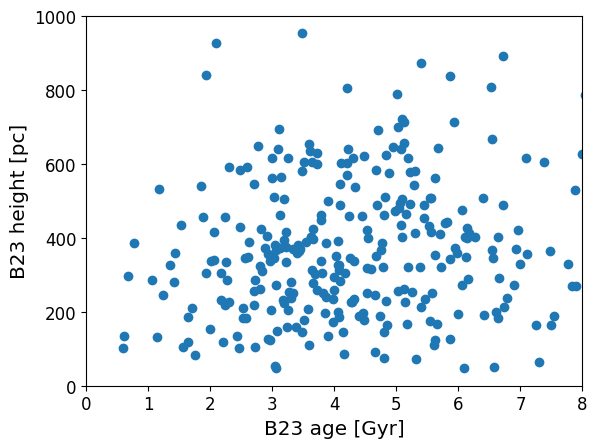

In [14]:
plt.scatter(k2_stars['iso_age'], k2_stars['zmax']*1000)
plt.ylim([0, 1000])
plt.xlim([0,8])
plt.xlabel('B23 age [Gyr]')
plt.ylabel('B23 height [pc]')
plt.show()

0      5.008
1      3.646
2      5.865
3      3.633
4      5.033
       ...  
337    4.095
338    3.628
339    6.549
340    3.474
341    2.200
Name: iso_age, Length: 342, dtype: float64
0      819.129868
1      314.431603
2      867.527710
3      570.357996
4      688.784606
          ...    
337    283.742707
338    383.956117
339    395.185597
340    957.028616
341    117.034435
Name: zmax, Length: 342, dtype: float64


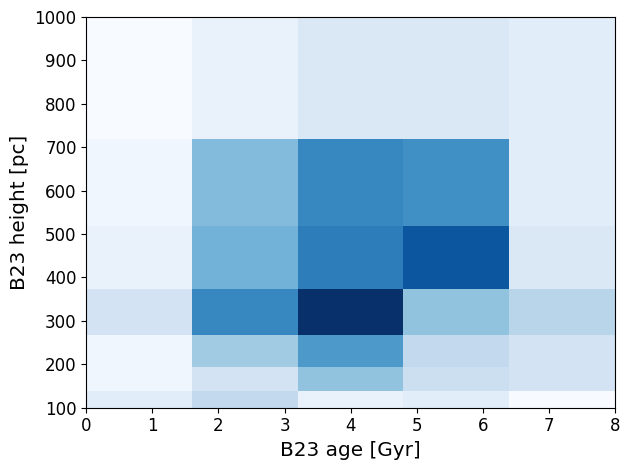

In [149]:
bins2d = [np.linspace(0, 8, 6), np.logspace(2, 3, 8)]

label='B23'
ages = k2_stars['iso_age']
heights = k2_stars['zmax']*1000
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B23':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B23 age [Gyr]')
	plt.ylabel('B23 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_B23.png')
plt.show()

Hmm, not enough stars overall to get a good signal out of the age vs height plot. But what if we bootstrapped a bunch of times? 

(Normally, I'd use simulate_helpers.draw_asymmetrically() out of the box, but the first line of the function pre-supposes Kepler IDs...oops)

In [15]:
def draw_asymmetrically(df, mode_name, err1_name, err2_name, drawn):
    """
    Draw stellar properties with asymmetric errors. 
    This is the generalized version of draw_star_ages(), below
    
    Inputs:
    - df: berger_kepler [Pandas DataFrame]
    - mode_name: name of mode column [string]
    - err1_name: name of err1 column [string]
    - err2_name: name of err2 column [string]
    - drawn: name of new column [string]

    Output:
    - df: berger_kepler_df, now with new column with drawn parameter, "drawn" [Pandas DataFrame]
    """

    # in case df is broken up by planet and not star
    uniques = df
    
    if drawn=='age':
        x = np.linspace(0.5, 13.5, 100)
    elif drawn=='gyro_age':
        x = np.linspace(0.5, 4., 100)
    elif drawn=='stellar_radius':
        x = np.linspace(0.5, 5., 100)
    elif drawn=='stellar_mass':
        x = np.linspace(0.5, 2.5, 100)
    elif drawn=='Teff':
        x = np.linspace(5300, 7500, 1000) # x = np.linspace(3700, 7500, 1000); Z23 did (4000, 6500, 1000)
    elif drawn=='stellar_feh':
        x = np.linspace(-0.5, 0.5, 100)
    elif drawn=='distance':
        x = np.linspace(0, 5000, 1000)
    elif drawn=='planet_radius':
        x = np.linspace(0.5, 10, 100)
    elif drawn=='logg':
        x = np.linspace(3.6, 4.7, 100)

    else: 
        print("Please create a column that is either age, gyro_age, stellar_radius, stellar_mass, distance, planet_radius, stellar_feh, or stellar_teff!")

    """
    TESTING
    print("x: ", x)
    pdf = make_pdf_rows(x, mode, err1, err2)
    pdf = pdf/np.sum(pdf)
    draw = np.around(np.random.choice(x, p=pdf), 2)
    print("draw: ", draw)
    """

    if drawn=='planet_radius':
        df_or_uniques = df
    else:
        df_or_uniques = uniques

    draws = np.ones(len(df_or_uniques))
    for i in range(len(df_or_uniques)):
        mode = df_or_uniques.iloc[i][mode_name]
        err1 = df_or_uniques.iloc[i][err1_name]
        err2 = np.abs(df_or_uniques.iloc[i][err2_name])
        
        #"""
        # symmetric uncertainties
        if err1==err2:
            draw = 0
            while draw <= 0: # make sure the draw is positive
                draw = np.around(np.random.normal(mode, err1), 2)

        # asymmetric uncertainties
        elif err1!=err2:
            pdf = simulate_helpers.make_pdf_rows(x, mode, err1, err2)
            pdf = pdf/np.sum(pdf)

            try:
                draw = 0
                while draw <= 0: # make sure the draw is positive
                    draw = np.around(np.random.choice(x, p=pdf), 2)
            except Exception as e:
                print("EXCEPTION: ", i, pdf, mode, err1, err2)
                print(e)
                break
                continue
        #"""

        """
        ### make all draws the same way, symmetric or asymmetric
        pdf = make_pdf_rows(x, mode, err1, err2)
        pdf = pdf/np.sum(pdf)

        try:
            draw = 0
            while draw <= 0: # make sure the draw is positive
                draw = np.around(np.random.choice(x, p=pdf), 2)
        except Exception as e:
            print("EXCEPTION: ", i, pdf, mode, err1, err2)
            print(e)
            break
        """

        #print(mode, err1, err2, draw)
        draws[i] = draw

    #print(len(df), len(draws), len(uniques))
    df_or_uniques[drawn] = draws

    # break back out into planet rows and forward fill across systems
    df = uniques.merge(df, how='right')
    df[drawn] = df[drawn].fillna(method='ffill')
    
    return df

### adapted from The Cannon project with Aida
def tighter_cull(comparison_df, comparison_teff, comparison_logg):

    comparison_df = comparison_df.loc[((comparison_logg<4.4) & (comparison_teff<6300))]
    comparison_df = comparison_df.loc[((comparison_logg>3.4) & (comparison_teff>5300))]

    return comparison_df


In [16]:
k2_stars_bootstrapped = pd.DataFrame()

for i in tqdm(range(30)):
	k2_stars_temp = draw_asymmetrically(k2_stars, 'iso_age', 'iso_age_err1', 'iso_age_err2', 'age')
	k2_stars_temp = draw_asymmetrically(k2_stars, 'iso_teff', 'iso_teff_err1', 'iso_teff_err2', 'Teff')
	k2_stars_temp = draw_asymmetrically(k2_stars, 'iso_logg', 'iso_logg_err1', 'iso_logg_err2', 'logg')
	# k2_stars_temp = draw_asymmetrically(k2_stars, 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'stellar_feh')
	k2_stars_bootstrapped = pd.concat([k2_stars_bootstrapped, k2_stars_temp])



100%|██████████| 30/30 [00:04<00:00,  7.00it/s]


Cull bootstrapped B23 K2 sample, to keep logg, Teff, and magnitudes within reasonable bounds, in prep for matched sampling.

In [17]:
print(len(k2_stars_bootstrapped))
k2_stars_bootstrapped = k2_stars_bootstrapped.loc[((k2_stars_bootstrapped['logg']<4.7) & (k2_stars_bootstrapped['logg']>3.6))]
k2_stars_bootstrapped = k2_stars_bootstrapped.loc[((k2_stars_bootstrapped['Teff']<6500) & (k2_stars_bootstrapped['Teff']>4900))] # this is redundant? no, here we remove post Kraft break stars
print(len(k2_stars_bootstrapped))


10260
9512


0      6.80
1      6.02
2      5.62
3      4.44
4      6.02
       ... 
337    6.67
338    3.65
339    8.12
340    3.39
341    1.81
Name: age, Length: 9516, dtype: float64
0      819.129868
1      314.431603
2      867.527710
3      570.357996
4      688.784606
          ...    
337    283.742707
338    383.956117
339    395.185597
340    957.028616
341    117.034435
Name: zmax, Length: 9516, dtype: float64


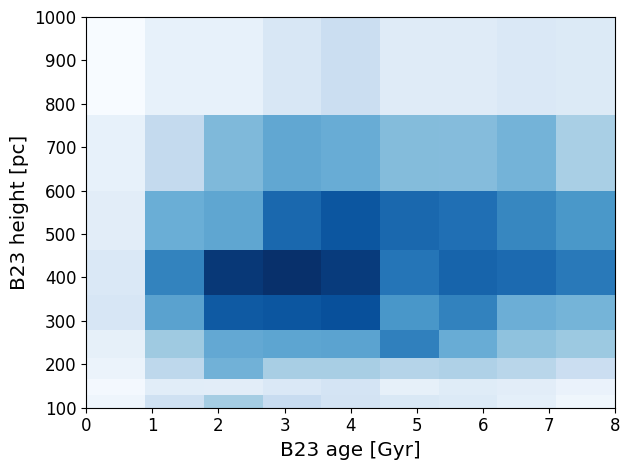

In [377]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='B23'
ages = k2_stars_bootstrapped['age']
heights = k2_stars_bootstrapped['zmax']*1000
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL age [Gyr]')
	plt.ylabel('TRILEGAL height [pc]')
elif label=='B23':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B23 age [Gyr]')
	plt.ylabel('B23 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_B23_bootstrapped.png')
plt.show()

#### 3D positions

Convert RAs and Decs of K2 fields to b

In [94]:
from astropy.coordinates import SkyCoord, Galactic

ra4 = 59.076
dec4 = 18.661

def convert_ra_dec_to_b(ra, dec):
	# Create a SkyCoord object in the ICRS (equatorial) frame
	# ICRS is the standard J2000 equatorial system assumed by default
	c_icrs = SkyCoord(ra=ra * u.degree, dec=dec * u.degree, frame='icrs')

	# Transform the coordinates to the Galactic frame
	c_galactic = c_icrs.transform_to(Galactic())
	# or use the shorthand attribute access:
	# c_galactic = c_icrs.galactic

	# The Galactic latitude 'b' is the angle from the Galactic midplane (b=0)
	b = c_galactic.b * u.degree
	
	return np.abs(b.value)

def ra_dec_to_b_l(ra, dec):
	c_icrs = SkyCoord(ra=ra, dec=dec, frame='icrs', unit='deg')

	# Transform the coordinates to the Galactic frame
	c_galactic = c_icrs.transform_to(Galactic())

	# The Galactic latitude 'b' is the angle from the Galactic midplane (b=0)
	b = c_galactic.b 
	l = c_galactic.l 

	return b, l

def degrees_to_radians(deg):
    return deg*np.pi/180

def dist_k2_to_height(d, b):
    """
    K2 fields have variable inclinations, so we need a second parameter, b, to do trigonometry.

    Inputs:
    - d: distance, in pc
    - b: inclination from Galactic midplane, in deg

    Output:
    - h: height off the Galactic midplane, in pc
    """

    incl = degrees_to_radians(b)
    h = d * np.sin(incl)

    return h

b4 = convert_ra_dec_to_b(ra4, dec4)
bs = []
for i in range(19):
    bs.append(convert_ra_dec_to_b(ras[i], decs[i]))

k2_pointings = dict({'campaign': campaigns, 'ra': ras, 'dec': decs, 'b': bs})
print(k2_pointings)

{'campaign': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]), 'ra': [173.93961, 246.1264, 336.66534641439, 59.0759116, 130.1576478, 204.8650344, 287.82850661, 16.3379975, 270.3544823, 186.779443, 260.3880064, 351.6588124, 72.7971166, 160.6824762, 233.617573, 133.7099689, 202.5496152, 130.161017, 347.2590265], 'dec': [1.4172989, -22.4473, -11.096663792177, 18.6605794, 16.829614, -11.2953585, -23.36001815, 5.2623459, -21.7798098, -4.0271572, -23.9759578, -5.1023328, 20.7870759, 6.8509316, -20.0792397, 18.5253931, -7.7210759, 16.8278629, -4.2027029], 'b': [58.531292937220314, 18.532959446605993, 52.42647045809778, 25.947332351078384, 31.51387163024061, 49.84903553228032, 14.570462204991587, 57.43518020338808, 0.5592168377172165, 58.29587273157315, 7.211487713852137, 60.11396589334712, 14.77267573551696, 53.350902824912026, 28.464777359996905, 35.2829262192038, 53.90825186787161, 31.51620958465847, 56.49896205637861]}


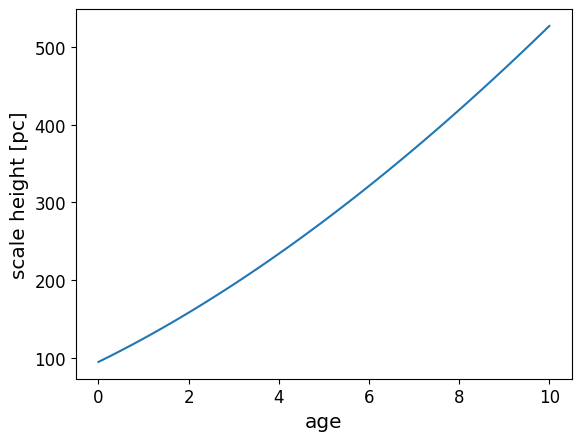

In [95]:
def scale_height_trilegal(t):
	"""
	Draw TRILEGAL scale height-age relation, to compare to empirical Kepler kinematic heating rate

	Args:
		t (float): age [Gyr]

	"""

	z0 = 94.7
	alpha = 1.6666
	t0 = 5.55

	h = z0 * (1 + t/t0)**alpha

	return h

t_linspace = np.linspace(0, 10, 100)
h_linspace = scale_height_trilegal(t_linspace)
plt.plot(t_linspace, h_linspace)
plt.ylabel('scale height [pc]')
plt.xlabel('age')
plt.show()

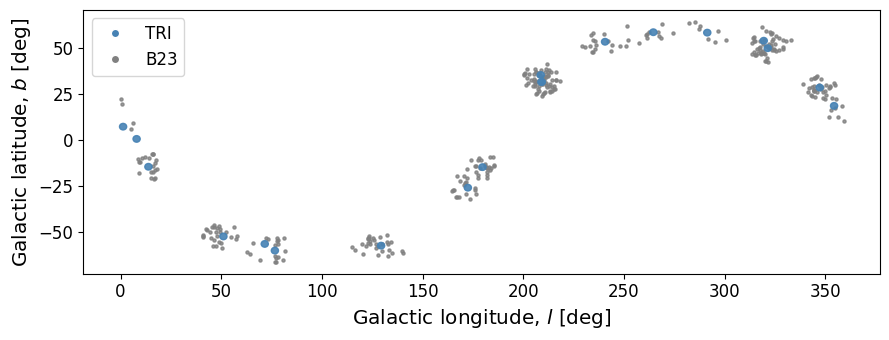

In [96]:
from matplotlib.lines import Line2D

# TRI
tri_k2_bs, tri_k2_ls = ra_dec_to_b_l(ras, decs)

fig, ax = plt.subplots(figsize=(9, 3.5))
for i in range(19):
    center = (tri_k2_ls[i].value, tri_k2_bs[i].value)
    
	# draw circle of radius sqrt(10), since the TRILEGAL queries have a window of 10 sq deg
    if i==0:
        circle = plt.Circle(center, np.sqrt(10/np.pi), alpha=0.9, color='steelblue', zorder=100, label='TRI')
    else:
        circle = plt.Circle(center, np.sqrt(10/np.pi), alpha=0.9, color='steelblue', zorder=100)

	# Add the circle to the axes
    ax.add_patch(circle)

# B23
k2_bs, k2_ls = ra_dec_to_b_l(k2_stars['ra'], k2_stars['dec'])

plt.scatter(k2_ls, k2_bs, label='B23', s=5, alpha=0.8, color='gray')

obj1 = Line2D([], [], color="white", marker='o', markerfacecolor="steelblue")
obj2 = Line2D([], [], color="white", marker='o', markerfacecolor="gray")
plt.legend((obj1, obj2), ('TRI', 'B23'))

plt.xlabel(r'Galactic longitude, $l$ [deg]')
plt.ylabel(r'Galactic latitude, $b$ [deg]')
plt.tight_layout()
plt.savefig(path+'plots/k2/pointings.png')
plt.show()


#### actual parameter draws for TRILEGAL

In [101]:
k2_stars.to_csv(path+'data/k2/k2_stars.csv')

In [138]:
import os
import re

stem = 'data/k2/trilegal/campaign' 
filenames = os.listdir(path+'data/k2/trilegal/')
tri_k2 = pd.DataFrame()
for i in range(len(filenames)):
	
	# there's a test file in this directory. skip it.
	if 'test' in filenames[i]:
		continue

	#temp_k2 = pd.read_csv(path+stem+f'{i+1}.dat.txt', sep='\s+')
	temp_k2 = pd.read_csv(path+'data/k2/trilegal/'+filenames[i], sep='\s+')
	temp_k2.dropna(subset=['logAge','m2/m1'], inplace=True)

	# remove end lines from TRILEGAL, if applicable
	try:
		temp_k2 = temp_k2[~temp_k2['logAge'].str.contains('normally', na=False)]
	except:
		pass

	# based on campaign, grab b of the pointing
	#temp_campaign = int(i)
	temp_campaign = int(re.search('campaign(.+?).dat', filenames[i]).group(1))
	temp_b = k2_pointings['b'][temp_campaign-1]
	#temp_b = k2_pointings[k2_pointings['campaign']==temp_campaign]['b']

	# add height column, introducing a spread of 0.05 dex based on TRILEGAL distance modulus bin size
	temp_k2['distance'] = simulate_helpers.distance_modulus_to_distance(temp_k2['m-M0'], perturb=True)
	temp_k2['height'] = dist_k2_to_height(temp_k2['distance'], temp_b)

	# add column for campaign and for whether it's high or low Galactic latitude
	temp_k2['campaign'] = temp_campaign

	tri_k2 = pd.concat([tri_k2, temp_k2])

print("initial TRI: ", len(tri_k2))

# remove binaries
tri_k2 = tri_k2[tri_k2['m2/m1']==0]
print("cut binaries: ", len(tri_k2))

# unlog Teff. keep FGK dwarfs only
tri_k2['Teff'] = 10**tri_k2['logTe'].astype(float)
#tri_k2 = tri_k2.loc[(tri_k2['Teff'] <= 6500) & (tri_k2['Teff'] >= 5300)] # keep only F and G dwarfs, pre-Kraft break
tri_k2 = tri_k2.loc[(tri_k2['Teff'] <= np.max(k2_stars_bootstrapped['Teff'])) & (tri_k2['Teff'] >= np.min(k2_stars_bootstrapped['Teff']))]
print("Teff cut: ", len(tri_k2))
print("max Teff: ", np.max(k2_stars_bootstrapped['Teff']))
print("min Teff: ", np.min(k2_stars_bootstrapped['Teff']))

# calculate stellar radius
tri_k2['stellar_radius'] = simulate_helpers.stellar_radius_stefan_boltzmann(10**tri_k2['logTe'], 10**tri_k2['logL'])

# remove giant based on B20 prescription
tri_k2['logR'] = np.log10(tri_k2['stellar_radius'])
tri_k2['is_giant'] = np.where(tri_k2['logR'] >= 0.00035*(tri_k2['Teff'] - 4500) + 0.15, True, False)
tri_k2 = tri_k2.loc[tri_k2['is_giant'] == False]
print("cut giants: ", len(tri_k2))

# remove poofy stars
tri_k2 = tri_k2.loc[(tri_k2['logg']<4.7) & (tri_k2['logg']>4.)]
print("logg cut: ", len(tri_k2))

# TRILEGAL logAge bin size is 0.02, so let's introduce a spread of that size; note from Luke Bouma (https://github.com/lgbouma/gyrojo/blob/main/gyrojo/trilegal.py#L92-L108)
eps = np.random.normal(loc=0, scale=0.02, size=len(tri_k2))
tri_k2['logAge'] = tri_k2['logAge'].astype(float)
tri_k2['logAge'] += eps
tri_k2['age'] = 10**tri_k2['logAge'].astype(float) / 1e9

# metallicity cuts
tri_k2 = tri_k2.loc[tri_k2['[M/H]'].astype(float)>=-0.25] # this is different from Fe/H cut for B23, but we only have apples v oranges
tri_k2 = tri_k2.loc[tri_k2['[M/H]'].astype(float)<=0.25]
print("metallicity cut: ", len(tri_k2))

# age cut for uniformity
tri_k2 = tri_k2.loc[tri_k2['age'] <= 12.]
print("min age: ", np.min(k2_stars_bootstrapped['age']))
tri_k2 = tri_k2.loc[tri_k2['age'] >= np.min(k2_stars_bootstrapped['age'])] 
print("age cut: ", len(tri_k2))

# make an additional cut on Kepler magnitude. actually I can't do that here because B23 doesn't have Kepmag
tri_k2 = tri_k2.loc[(tri_k2['Kepler'] <= np.max(k2_stars_candidates['k2_kmag'])) & (tri_k2['Kepler'] >= np.min(k2_stars_candidates['k2_kmag']))] 
print("kepmag cut: ", len(tri_k2))
print("min kepmag: ", np.min(k2_stars_candidates['k2_kmag']))
print("max kepmag: ", np.max(k2_stars_candidates['k2_kmag']))

# extrapolate CDPP based on Zink+20
#my_k2 = simulate_helpers.kepmag_to_cdpp_vectorized(k2_stars, my_k2) # cdpp distribution is similar to B20 sample

tri_k2 = tri_k2.reset_index()
tri_k2


initial TRI:  842457
cut binaries:  496124
Teff cut:  123197
max Teff:  7410.610610610611
min Teff:  4873.473473473474
cut giants:  90761
logg cut:  80537
metallicity cut:  49777
min age:  0.5
age cut:  40494
kepmag cut:  10318
min kepmag:  7.425
max kepmag:  13.91


,index,#Gc,logAge,[M/H],m_ini,logL,logTe,logg,m-M0,Av,...,Ks,Mact,distance,height,campaign,Teff,stellar_radius,logR,is_giant,age
0,43,1,8.859355,-0.13,1.36216,0.603,3.844,4.290,7.173993,0.035,...,9.592,1.362,272.143864,142.250952,5,6982.324041,1.371470,0.137186,False,0.723361
1,45,1,8.845005,0.17,1.00134,-0.163,3.740,4.506,7.032718,0.034,...,10.595,1.001,255.001985,133.290807,5,5495.408739,0.916613,-0.037814,False,0.699850
2,52,1,8.901907,-0.07,1.37716,0.611,3.839,4.268,7.039370,0.034,...,9.386,1.377,255.784410,133.699784,5,6902.398038,1.416401,0.151186,False,0.797823
3,66,1,8.953293,0.05,1.49498,0.756,3.845,4.182,8.968054,0.038,...,11.064,1.495,621.742790,324.988051,5,6998.419960,1.628119,0.211686,False,0.898035
4,71,1,8.955402,-0.01,0.94095,-0.249,3.734,4.542,8.385536,0.037,...,11.972,0.941,475.452539,248.521409,5,5420.008904,0.853466,-0.068814,False,0.902407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10313,2758,1,9.907461,-0.19,0.85677,-0.243,3.740,4.518,8.282357,0.036,...,11.952,0.857,453.389438,346.547379,6,5495.408739,0.835961,-0.077814,False,8.080919
10314,2766,1,9.852972,-0.17,1.00175,0.206,3.777,4.286,8.545288,0.037,...,11.497,1.002,511.749785,391.155002,6,5984.115951,1.182187,0.072686,False,7.128064
10315,2772,1,9.896071,-0.15,0.84281,-0.306,3.730,4.535,7.778408,0.035,...,11.639,0.843,359.485717,274.772243,6,5370.317964,0.814116,-0.089314,False,7.871751
10316,2908,1,9.917772,-0.25,0.95038,0.093,3.774,4.366,9.277293,0.038,...,12.362,0.950,716.899917,547.961126,6,5942.921586,1.052413,0.022186,False,8.275069


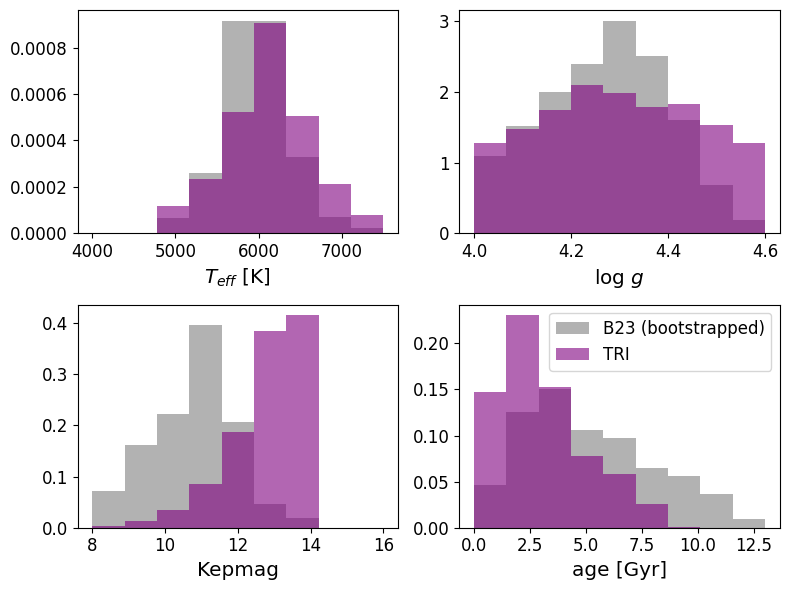

In [139]:
cols = ["iso_teff", "iso_logg", "kepmag", "iso_age"]

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

"""
for i, col in enumerate(cols):
    ax = axes[i]

    ax.hist(kepler_stars_bedell_df_kepmag[col], bins=20, alpha=0.6, label="B20 (bootstrapped)", density=True, color='gray')
    #ax.hist(tri_kepler[col], bins=20, alpha=0.6, label="TRI", density=True, color='purple')
    ax.hist(tri_matched_to_b23_kepler[col], bins=20, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')

    ax.set_xlabel(col)
    #ax.set_ylabel()
    if i==3:
        ax.legend(loc='upper right')
"""

ax = axes[0]
teff_bins = np.linspace(4000, 7500, 10)
ax.hist(k2_stars_bootstrapped['Teff'], bins=teff_bins, alpha=0.6, label="B23 (bootstrapped)", density=True, color='gray')
ax.hist(tri_k2['Teff'], bins=teff_bins, alpha=0.6, label="TRI", density=True, color='purple')
#ax.hist(tri_matched_to_b23_kepler_logg['Teff'], bins=teff_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r"$T_{eff}$ [K]")

ax = axes[1]
logg_bins = np.linspace(4., 4.6, 10)
ax.hist(k2_stars_bootstrapped['logg'], bins=logg_bins, alpha=0.6, label="B23 (bootstrapped)", density=True, color='gray')
ax.hist(tri_k2['logg'], bins=logg_bins, alpha=0.6, label="TRI", density=True, color='purple')
#ax.hist(tri_matched_to_b23_kepler_logg['logg'], bins=logg_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r'log $g$')

ax = axes[2]
kepmag_bins = np.linspace(8, 16, 10)
ax.hist(k2_stars_candidates['k2_kmag'], bins=kepmag_bins, alpha=0.6, label="B23 (bootstrapped)", density=True, color='gray')
ax.hist(tri_k2['Kepler'], bins=kepmag_bins, alpha=0.6, label="TRI", density=True, color='purple')
#ax.hist(tri_matched_to_b23_kepler_logg['kepmag'], bins=kepmag_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r'Kepmag')

ax = axes[3]
age_bins = np.linspace(0, 13, 10)
ax.hist(k2_stars_bootstrapped['age'], bins=age_bins, alpha=0.6, label="B23 (bootstrapped)", density=True, color='gray')
ax.hist(tri_k2['age'], bins=age_bins, alpha=0.6, label="TRI", density=True, color='purple')
#ax.hist(tri_matched_to_b23_kepler_logg['age'], bins=age_bins, alpha=0.6, label="TRI (match sampled)", density=True, color='steelblue')
ax.set_xlabel(r'age [Gyr]')
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(path+'plots/k2/tri_vs_b23_params.png')
plt.show()

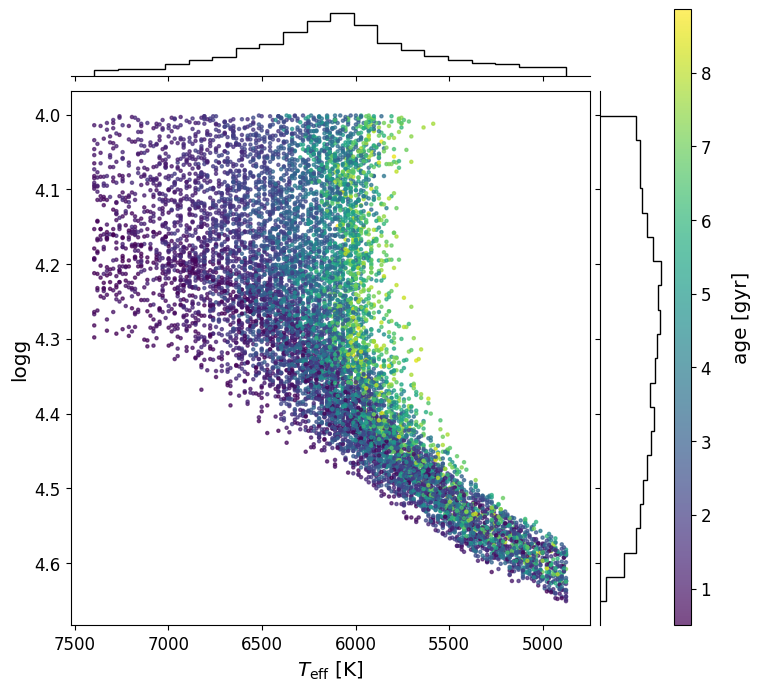

In [134]:
from matplotlib.gridspec import GridSpec

# figure and grid layout
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(2, 3, figure=fig, wspace=0.05, hspace=0.05, width_ratios=[8, 1, 0.25], height_ratios=[1, 8]) # two horizontal assets, but third vertical asset required for colorbar

# main scatter plot spans bottom-left
ax_scatter = fig.add_subplot(gs[1, 0])

# top histogram spans top-left
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax_scatter)
pos = ax_histx.get_position()
ax_histx.set_position([pos.x0, pos.y0 + 0.00, pos.width, pos.height])
ax_histx.set_yticks([])

# right histogram spans bottom-right
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_scatter)
ax_histy.set_xticks([])
im = ax_scatter.scatter(tri_k2['Teff'], tri_k2['logg'], s=5, alpha=0.7, c=tri_k2['age'])

# histograms
ax_histx.hist(tri_k2['Teff'], bins=20, histtype='step', color="k", linewidth=1)
ax_histy.hist(tri_k2['logg'], bins=20, orientation='horizontal', histtype='step', color="k", linewidth=1)
ax_histx.invert_xaxis()
ax_histy.invert_yaxis()
#ax_histy.invert_xaxis()

# tidy up shared axes
plt.setp(ax_histx.get_xticklabels(), visible=False)
plt.setp(ax_histy.get_yticklabels(), visible=False)
#fig.subplots_adjust(hspace=1.25)   # increase vertical spacing

# remove spines from histograms
ax_histx.spines['right'].set_visible(False)
ax_histx.spines['top'].set_visible(False)
ax_histx.spines['left'].set_visible(False)

ax_histy.spines['right'].set_visible(False)
ax_histy.spines['top'].set_visible(False)
ax_histy.spines['bottom'].set_visible(False)

# add colorbar as final asset
ax_cbar = fig.add_subplot(gs[:, 2])

ax_scatter.set_xlabel(r"$T_{\rm eff}$ [K]")
ax_scatter.set_ylabel('logg')
#plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
#ax_scatter.set_xlim([7600, 3900])
#ax_scatter.set_ylim([4.7, 3.6])
#plt.legend(fontsize='medium')
#plt.legend(loc='upper left', bbox_to_anchor=(0.02, 1.0), fontsize='medium')
#cbar = plt.colorbar(im, cmap='viridis', label='age [Gyr]')
cbar = fig.colorbar(im, cax=ax_cbar)
cbar.set_label('age [gyr]', labelpad=15)
cbar.ax.yaxis.set_label_position("right")
plt.tight_layout()
plt.savefig(path+'plots/k2/kiel_tri_k2.png')
plt.show()

0        0.723361
1        0.699850
2        0.797823
3        0.898035
4        0.902407
           ...   
10313    8.080919
10314    7.128064
10315    7.871751
10316    8.275069
10317    8.105181
Name: age, Length: 10318, dtype: float64
0        142.250952
1        133.290807
2        133.699784
3        324.988051
4        248.521409
            ...    
10313    346.547379
10314    391.155002
10315    274.772243
10316    547.961126
10317    468.139029
Name: height, Length: 10318, dtype: float64


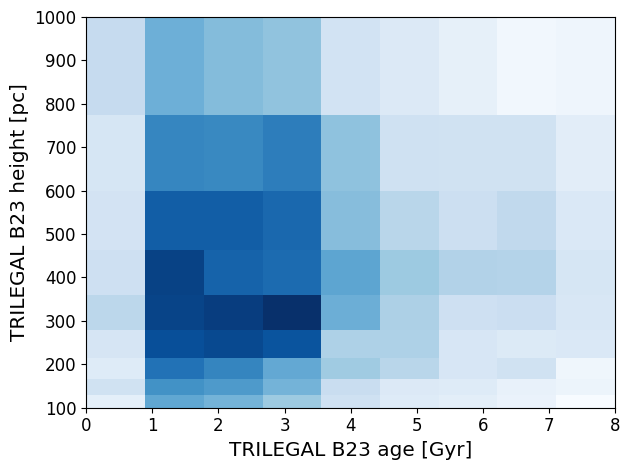

In [142]:
bins2d = [np.linspace(0, 8, 10), np.logspace(2, 3, 10)]

label='TRI'
ages = tri_k2['age']
heights = tri_k2['height']
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(ages, heights, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL B23 age [Gyr]')
	plt.ylabel('TRILEGAL B23 height [pc]')
elif label=='B23':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B23 age [Gyr]')
	plt.ylabel('B23 height [pc]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
plt.savefig(path+'plots/k2/age_vs_height_tri_k2_bootstrapped.png')
plt.show()

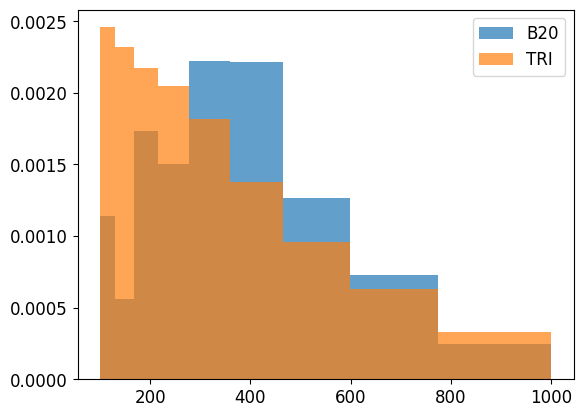

median B23:  386.9656380966584
median TRI:  269.5385305360261
mean B23:  427.98307289833906
mean TRI:  336.7376662150527


In [146]:
plt.hist(k2_stars_bootstrapped['height']*1000, density=True, bins=np.logspace(2,3,10), alpha=0.7, label='B20')
plt.hist(tri_k2['height'], density=True, bins=np.logspace(2,3,10), alpha=0.7, label='TRI')
plt.legend()
plt.show()

print("median B23: ", np.nanmedian(k2_stars_bootstrapped['height']*1000))
print("median TRI: ", np.nanmedian(tri_k2['height']))
print("mean B23: ", np.nanmean(k2_stars_bootstrapped['height']*1000))
print("mean TRI: ", np.nanmean(tri_k2['height']))

### Paint planets to synthetic stellar sample

In [161]:
k2_stars_candidates_cdpp = pd.merge(k2_stars_candidates, k2_cdpps[['EPIC', 'CDPP60']], on='EPIC')
k2_stars_candidates_cdpp.drop_duplicates('EPIC')

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,radial_velocity_error,parallax,zmax,height,logR,is_giant,epic_number,k2_kmag,k2_kmagerr,CDPP60
0,epic211391664,6439.884360,202.637724,-201.633114,4.211465,0.060810,-0.067157,-0.044928,0.146261,-0.152992,...,0.811065,1.949978,0.226562,0.223775,0.148939,False,211391664,10.869,0.028,10052.151
2,epic211401787,6288.272568,185.892108,-165.000457,4.218837,0.061133,-0.059118,-0.033877,0.151985,-0.135407,...,0.307481,6.332836,0.130701,0.127580,0.119975,False,211401787,8.412,0.023,22.419
4,epic211539054,6082.023780,187.869356,-155.316777,4.204944,0.061788,-0.065497,0.082594,0.134860,-0.153289,...,0.279308,4.417026,0.338186,0.337818,0.119975,False,211539054,9.163,0.017,33.859
6,epic211770867,6418.103437,212.218248,-180.705471,4.104885,0.065587,-0.056217,-0.195719,0.138574,-0.130969,...,3.044293,1.702683,0.353381,0.333943,0.201645,False,211770867,10.881,0.018,38.704
8,epic211923431,5559.684366,162.935564,-162.190112,4.371631,0.081514,-0.077014,-0.154724,0.125220,-0.139392,...,4.540085,1.425554,0.343217,0.370250,0.019305,False,211923431,12.435,0.023,97.243
10,epic211945201,6137.481807,156.008100,-179.090943,4.271403,0.057437,-0.061594,0.099199,0.138787,-0.151251,...,0.265824,5.563653,0.458800,0.454076,0.134699,False,211945201,8.837,0.020,38.319
12,epic212006318,5885.321100,168.380735,-175.554953,4.155636,0.067240,-0.076667,0.023732,0.131773,-0.154624,...,1.478502,1.472585,0.490985,0.490978,0.176091,False,212006318,11.557,0.018,41.493
14,epic212110888,6370.694555,151.374076,-181.406735,4.286633,0.046968,-0.059869,-0.001760,0.138109,-0.133040,...,0.660542,2.922210,0.302674,0.305668,0.104735,False,212110888,10.193,0.017,36.559
17,epic212130773,5014.594818,109.947015,-110.697613,4.524739,0.059485,-0.060426,-0.123906,0.136315,-0.131443,...,5.933782,2.121726,0.253478,0.259747,-0.087150,False,212130773,12.260,0.022,111.853
19,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.576840,2.195042,0.286814,0.282481,0.201645,False,211784767,10.560,0.019,41.227


Well that's not great. I'm gonna need to do a lot of interpolating.

In [208]:
k2_cdpps_enriched = pd.merge(k2_cdpps, k2candidates, left_on='EPIC', right_on='epic_number')
k2_cdpps_enriched = k2_cdpps_enriched.loc[k2_cdpps_enriched['CDPP60']<=1000]
k2_cdpps_enriched

,EPIC,CDPP10,CDPP15,CDPP20,CDPP25,CDPP30,CDPP40,CDPP50,CDPP60,CDPP70,...,k2_mass,k2_masserr1,k2_masserr2,k2_kepmag,k2_kepmagerr,k2_kepmagflag,k2_vjmag,k2_vjmagerr,k2_kmag,k2_kmagerr
0,211757991,144.911,136.083,121.719,113.490,109.661,98.879,92.864,92.992,88.813,...,0.85,0.06,-0.08,13.361,NaN,gri,13.629,0.030,11.361,0.020
1,211757991,144.911,136.083,121.719,113.490,109.661,98.879,92.864,92.992,88.813,...,NaN,NaN,NaN,13.361,NaN,gri,13.629,0.030,11.361,0.020
4,211682710,108.918,89.812,82.123,69.502,64.331,58.029,51.374,46.896,42.640,...,0.91,0.15,-0.07,13.204,NaN,gri,13.548,0.050,11.274,0.019
5,211429539,1281.174,1020.636,917.835,835.924,780.876,687.515,641.885,579.331,551.914,...,0.56,0.10,-0.12,16.758,NaN,BV,17.110,0.105,13.646,0.037
6,211429539,1281.174,1020.636,917.835,835.924,780.876,687.515,641.885,579.331,551.914,...,NaN,NaN,NaN,16.758,NaN,BV,17.110,0.105,13.646,0.037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42568,211409713,847.386,812.311,748.193,760.363,766.329,758.434,805.998,817.012,850.587,...,1.07,0.15,-0.15,12.491,NaN,gri,12.601,0.020,11.147,0.026
42569,211409713,847.386,812.311,748.193,760.363,766.329,758.434,805.998,817.012,850.587,...,NaN,NaN,NaN,12.491,NaN,gri,12.601,0.020,11.147,0.026
42570,211566738,360.844,320.730,266.292,268.193,251.256,207.198,179.743,157.887,140.017,...,0.53,0.06,-0.06,14.927,NaN,gri,15.641,0.030,11.729,0.017
42571,211566738,360.844,320.730,266.292,268.193,251.256,207.198,179.743,157.887,140.017,...,NaN,NaN,NaN,14.927,NaN,gri,15.641,0.030,11.729,0.017


0        0.723361
1        0.699850
2        0.797823
3        0.898035
4        0.902407
           ...   
10313    8.080919
10314    7.128064
10315    7.871751
10316    8.275069
10317    8.105181
Name: age, Length: 10318, dtype: float64
0        142.250952
1        133.290807
2        133.699784
3        324.988051
4        248.521409
            ...    
10313    346.547379
10314    391.155002
10315    274.772243
10316    547.961126
10317    468.139029
Name: height, Length: 10318, dtype: float64


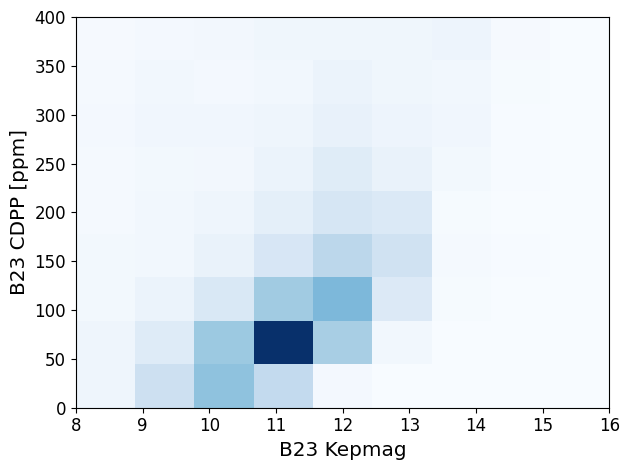

In [209]:
bins2d = [np.linspace(8, 16, 10), np.linspace(0, 400, 10)]

label='B23'
kepmag = k2_cdpps_enriched['k2_kmag']
cdpps = k2_cdpps_enriched['CDPP60']
norm = 10
print(ages)
print(heights)
hist, xedges, yedges = np.histogram2d(kepmag, cdpps, bins=bins2d)
hist = hist.T

normalized = False
if normalized==True:
	with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
		hist *= norm / hist.sum(axis=0, keepdims=True)
		#hist *= norm / hist.sum(axis=1, keepdims=True)
if label=='TRI':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('TRILEGAL B23 age [Gyr]')
	plt.ylabel('TRILEGAL B23 height [pc]')
elif label=='B23':
	ax = plt.pcolormesh(xedges, yedges, hist, cmap='Blues')
	plt.xlabel('B23 Kepmag')
	plt.ylabel('B23 CDPP [ppm]')
#plt.legend(bbox_to_anchor=(1., 1.05))
plt.tight_layout()
#plt.savefig(path+'plots/k2/age_vs_height_tri_k2_bootstrapped.png')
plt.show()

In [224]:
def kepmag_to_cdpp_vectorized(data1, data2):

    """
    Use Kepler mag vs CDPP (6 hr) relation from Berger Kepler-Gaia crossmatch to infer CDPP given simulated kepmag from TRILEGAL, etc
    Fold in Teff and galactic height, since these bear indirectly on noise properties and directly on experimental dependent variables
    Inputs:
    - data1: reference DataFrame, with Kepler mag and CDPP
    - data2: target DataFrame from which to sample

    Output:
    #- cdpps: new array of CDPPs
    - new_data2: this operation culls records that have NaN heights, etc. So let's use this opportunity to cull the entire DF, rather than output a column of different length from the original
    """

    cols_to_match = ['mag_bins', 'teff_bins', 'stellar_radius_bins']
    logg_bins = np.linspace(4.0, 4.6, 5) 
    teff_bins = np.linspace(5000, 7500, 25) # (5300, 7500, 50) or (4000, 6500, 50)
    mag_bins = np.linspace(8, 16, 9)
    age_bins = np.linspace(0, 12, 10) # (0, 14, 10) or (0, 8, 10)
    stellar_radius_bins = np.linspace(1, 3.5, 5)
    cdpp_bins = np.linspace(0, 1000, 10) # (0, 100, 10)
    height_bins = np.logspace(2,3,6)
    
    # reference DataFrame
    data1['mag_bins'] = pd.cut(data1['k2_kmag'], bins=mag_bins, include_lowest=True)
    #data1['logg_bins'] = pd.cut(data1['k2_logg'], bins=logg_bins, include_lowest=True)
    data1['teff_bins'] = pd.cut(data1['k2_teff'], bins=teff_bins, include_lowest=True)
    data1['stellar_radius_bins'] = pd.cut(data1['k2_rad'], bins=stellar_radius_bins, include_lowest=True)
    #data1['cdpp_bins'] = pd.cut(data1['rrmscdpp06p0'], bins=cdpp_bins, include_lowest=True)
    #data1['height_bins'] = pd.cut(data1['height'], bins=height_bins, include_lowest=True)
    #data1['age_bins'] = pd.cut(data1['age'], bins=age_bins, include_lowest=True)

    data1_cdpp_mean = data1.groupby(cols_to_match)['CDPP60'].mean().reset_index()
    data1_cdpp_mean = data1_cdpp_mean.pivot(index='mag_bins', columns=cols_to_match[1:])

    data1_cdpp_std = data1.groupby(cols_to_match)['CDPP60'].std().reset_index()
    data1_cdpp_std = data1_cdpp_std.pivot(index='mag_bins', columns=cols_to_match[1:])

    # unstack pivot tables
    data1_unstacked_mean = data1_cdpp_mean.unstack().reset_index()
    data1_unstacked_mean = data1_unstacked_mean[['mag_bins', 'teff_bins', 'stellar_radius_bins', 0]]
    data1_unstacked_mean.columns = ['mag_bins', 'teff_bins', 'stellar_radius_bins', 'cdpp_mean']
    data1_unstacked_mean.dropna(subset=['cdpp_mean'], inplace=True)
    print(data1_unstacked_mean)

    data1_unstacked_std = data1_cdpp_std.unstack().reset_index()
    data1_unstacked_std = data1_unstacked_std[['mag_bins', 'teff_bins', 'stellar_radius_bins', 0]]
    data1_unstacked_std.columns = ['mag_bins', 'teff_bins', 'stellar_radius_bins', 'cdpp_std']
    data1_unstacked_std.dropna(subset=['cdpp_std'], inplace=True)
    print(data1_unstacked_std)

    # target DataFrame from which to sample
    data2['mag_bins'] = pd.cut(data2['k2_kmag'], bins=mag_bins, include_lowest=True)
    #data2['logg_bins'] = pd.cut(data2['logg'], bins=logg_bins, include_lowest=True)
    data2['teff_bins'] = pd.cut(data2['Teff'], bins=teff_bins, include_lowest=True)
    data2['stellar_radius_bins'] = pd.cut(data2['stellar_radius'], bins=stellar_radius_bins, include_lowest=True)
    #data2['cdpp_bins'] = pd.cut(data2['cdpp'], bins=cdpp_bins, include_lowest=True)
    #data2['height_bins'] = pd.cut(data2['height'], bins=height_bins, include_lowest=True)
    #data2['age_bins'] = pd.cut(data2['age'], bins=age_bins, include_lowest=True)
    #print(data2)

    # merge the DataFrames on the multiple columns
    new_data2 = pd.merge(data2, data1_unstacked_mean, on=cols_to_match, how='inner')
    new_data2.dropna(subset=['cdpp_mean'], inplace=True)

    new_data2 = pd.merge(new_data2, data1_unstacked_std, on=cols_to_match, how='inner')
    new_data2.dropna(subset=['cdpp_std'], inplace=True)
    #print(new_data2)

    # sample from target
    new_data2['cdpp'] = np.random.normal(new_data2['cdpp_mean'], new_data2['cdpp_std'])

    return new_data2

(array([1347., 1052.,  723.,  521.,  395.,  364.,  435.,  512.,  662.,
         829.,  798.,  703.,  463.,  259.,  157.,   71.,   56.,   41.,
          37.,   10.,   10.,    9.,    8.,   15.]),
 array([5000.        , 5104.16666667, 5208.33333333, 5312.5       ,
        5416.66666667, 5520.83333333, 5625.        , 5729.16666667,
        5833.33333333, 5937.5       , 6041.66666667, 6145.83333333,
        6250.        , 6354.16666667, 6458.33333333, 6562.5       ,
        6666.66666667, 6770.83333333, 6875.        , 6979.16666667,
        7083.33333333, 7187.5       , 7291.66666667, 7395.83333333,
        7500.        ]),
 <BarContainer object of 24 artists>)

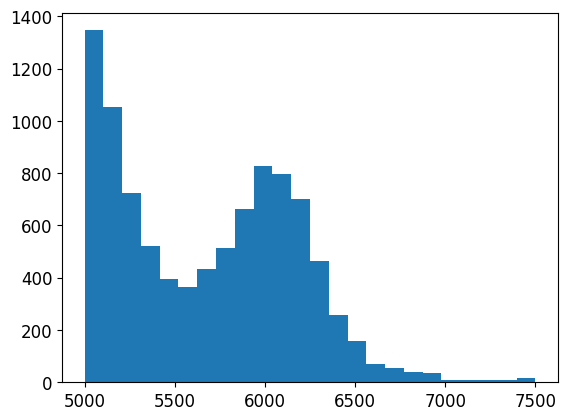

In [217]:
plt.hist(k2_cdpps_enriched['k2_teff'], bins=np.linspace(5000, 7500, 25))

In [222]:
k2_snippet = k2_cdpps_enriched.loc[(k2_cdpps_enriched['k2_kmag']<=9)&(k2_cdpps_enriched['k2_teff']<=5104)&(k2_cdpps_enriched['k2_rad']<=1.625)]

(array([34.,  7.,  3.,  4.,  0.,  2.,  3.,  2.,  0.,  1.]),
 array([ 19.444 , 106.0482, 192.6524, 279.2566, 365.8608, 452.465 ,
        539.0692, 625.6734, 712.2776, 798.8818, 885.486 ]),
 <BarContainer object of 10 artists>)

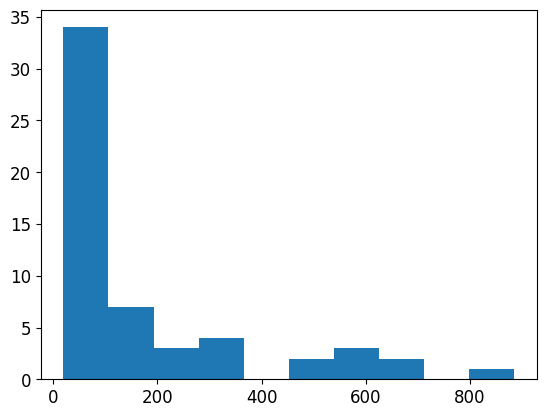

In [223]:
plt.hist(k2_snippet['CDPP60'])

In [226]:
k2_cdpp_matched = kepmag_to_cdpp_vectorized(k2_cdpps_enriched, k2_stars_candidates)
k2_cdpp_matched['cdpp']

         mag_bins             teff_bins stellar_radius_bins   cdpp_mean
4    (12.0, 13.0]  (4999.999, 5104.167]      (0.999, 1.625]  219.895500
9     (9.0, 10.0]  (4999.999, 5104.167]       (1.625, 2.25]   95.193000
10   (10.0, 11.0]  (4999.999, 5104.167]       (1.625, 2.25]   94.365500
11   (11.0, 12.0]  (4999.999, 5104.167]       (1.625, 2.25]  127.167273
12   (12.0, 13.0]  (4999.999, 5104.167]       (1.625, 2.25]  192.748677
..            ...                   ...                 ...         ...
744  (7.999, 9.0]    (7395.833, 7500.0]       (1.625, 2.25]   72.852000
745   (9.0, 10.0]    (7395.833, 7500.0]       (1.625, 2.25]  334.768667
746  (10.0, 11.0]    (7395.833, 7500.0]       (1.625, 2.25]   80.149750
747  (11.0, 12.0]    (7395.833, 7500.0]       (1.625, 2.25]  339.762333
752  (7.999, 9.0]    (7395.833, 7500.0]       (2.25, 2.875]  403.348000

[248 rows x 4 columns]
         mag_bins             teff_bins stellar_radius_bins    cdpp_std
4    (12.0, 13.0]  (4999.999, 5104.167] 

0       75.960554
1      -35.858718
2       22.362352
3      -40.979941
4       94.987775
          ...    
982    135.426887
983     80.960847
984     45.015175
985    202.797540
986    244.606129
Name: cdpp, Length: 987, dtype: float64

In [243]:
k2_stars_bootstrapped_enriched = pd.merge(k2_stars_bootstrapped, k2_cdpp_matched[['EPIC','cdpp','k2_kmag']], on='EPIC')
k2_stars_bootstrapped_enriched

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,pmra_error,pmdec_error,radial_velocity_error,parallax,zmax,height,logR,is_giant,cdpp,k2_kmag
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.023659,0.011433,0.764247,2.157181,0.810513,0.792691,0.176091,False,75.960554,10.693
1,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.023659,0.011433,0.764247,2.157181,0.810513,0.792691,0.176091,False,-67.773123,10.693
2,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.023659,0.011433,0.764247,2.157181,0.810513,0.792691,0.176091,False,75.487403,10.693
3,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.023659,0.011433,0.764247,2.157181,0.810513,0.792691,0.176091,False,94.527241,10.693
4,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.023659,0.011433,0.764247,2.157181,0.810513,0.792691,0.176091,False,152.155903,10.693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9270,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.019146,0.014207,0.576840,2.195042,0.286814,0.282481,0.201645,False,-194.369889,10.560
9271,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.019146,0.014207,0.576840,2.195042,0.286814,0.282481,0.201645,False,-5.667418,10.560
9272,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.019146,0.014207,0.576840,2.195042,0.286814,0.282481,0.201645,False,-48.210959,10.560
9273,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.019146,0.014207,0.576840,2.195042,0.286814,0.282481,0.201645,False,202.797540,10.560


In [ ]:
def recovery_fraction(x):

	"""Equation 6 of Zink+22, https://iopscience.iop.org/article/10.3847/1538-3881/ac2309#ajac2309t3
	a, k, l values from Table 3 of Zink+22. Specifically AFGK dwarf row.

	Input:
	    x: MES, multiple event statistic 
	Returns:
		f: recovery fraction
	"""

	a = 0.6095
	k = 0.6088
	l = 10.8986

	f = a/(1+np.exp(-k*(x-l)))

	return f

def mes(rp, rstar, cdpp, n_transits):

	C = 0.9488
	rp = simulate_helpers.earth_radius_to_au(rp)
	rstar = simulate_helpers.solar_radius_to_au(rstar)
	depth = (rp/rstar)**2

	mes = C * depth/cdpp * np.sqrt(n_transits)

	return mes

def n_transits(campaign, period):
	"""Take K2 field and planet period to calculate number of transits

	Args:
		campaign (int): K2 Campaign, which has variable length
		period (float): planet orbital period

	Returns:
		n_transits (int): number of transits
	"""

	return n_transits

oops, how did I not have campaign number this whole time?

In [244]:
k2_stars_bootstrapped_enriched = pd.merge(k2_stars_bootstrapped_enriched, k2candidates[['epic_number','k2_campaign_str']], left_on='EPIC', right_on='epic_number')
k2_stars_bootstrapped_enriched

,id_starname,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,iso_feh,iso_feh_err1,iso_feh_err2,...,radial_velocity_error,parallax,zmax,height,logR,is_giant,cdpp,k2_kmag,epic_number,k2_campaign_str
0,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.764247,2.157181,0.810513,0.792691,0.176091,False,75.960554,10.693,201295312,1
1,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.764247,2.157181,0.810513,0.792691,0.176091,False,-67.773123,10.693,201295312,1
2,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.764247,2.157181,0.810513,0.792691,0.176091,False,75.487403,10.693,201295312,1
3,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.764247,2.157181,0.810513,0.792691,0.176091,False,94.527241,10.693,201295312,1
4,epic201295312,5931.032127,169.153647,-166.330894,4.165348,0.061937,-0.070476,0.155635,0.149923,-0.134804,...,0.764247,2.157181,0.810513,0.792691,0.176091,False,152.155903,10.693,201295312,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12678,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.576840,2.195042,0.286814,0.282481,0.201645,False,-48.210959,10.560,211784767,18
12679,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.576840,2.195042,0.286814,0.282481,0.201645,False,202.797540,10.560,211784767,5
12680,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.576840,2.195042,0.286814,0.282481,0.201645,False,202.797540,10.560,211784767,18
12681,epic211784767,6043.134408,179.599281,-167.443695,4.144299,0.061201,-0.063427,0.069388,0.136802,-0.147710,...,0.576840,2.195042,0.286814,0.282481,0.201645,False,244.606129,10.560,211784767,5


In [ ]:
mes()

In [ ]:
# draw eccentricities using Van Eylen+ 2019
model_flag = 'rayleigh'

# planet formation history model parameters
threshold = 11 # cosmic age in Gyr; 13.7 minus stellar age, then round
frac1 = 0.33 # frac1 must be < frac2 if comparing cosmic ages
frac2 = 0.33

name_thresh = 11
name_f1 = 33
name_f2 = 33
name = 'step_'+str(name_thresh)+'_'+str(name_f1)+'_'+str(name_f2)

physical_planet_occurrences = []
physical_planet_occurrences_precut = []
detected_planet_occurrences_all = []
adjusted_planet_occurrences_all = []
transit_multiplicities_all = []
geom_transit_multiplicities_all = []
completeness_all = []
# for each model, draw around stellar age errors 10 times
for j in tqdm(range(5)): 
    
	### create a Population object to hold information about the occurrence law governing that specific population
    # THIS IS WHERE YOU CHOOSE THE PLANET FORMATION HISTORY MODEL YOU WANT TO FORWARD MODEL
    pop = Population(k2_stars_bootstrapped['age'], threshold, frac1, frac2)
    frac_hosts = pop.galactic_occurrence_step(threshold, frac1, frac2)
    #frac_hosts = pop.galactic_occurrence_monotonic(frac1, frac2)
    #frac_hosts = pop.galactic_occurrence_piecewise(frac1, frac2, threshold)
    intact_fracs = scipy.stats.truncnorm.rvs(0, 1, loc=0.18, scale=0.1, size=len(k2_stars_bootstrapped))  

    alpha_se = np.random.normal(-1., 0.2)
    alpha_sn = np.random.normal(-1.5, 0.1)
    
	# create Star objects, with their planetary systems
    star_data = []
    for i in tqdm(range(len(k2_stars_bootstrapped))): # 100
        star = Star(k2_stars_bootstrapped['age'][i], k2_stars_bootstrapped['stellar_radius'][i], k2_stars_bootstrapped['stellar_mass'][i], k2_stars_bootstrapped['Teff'][i], k2_stars_bootstrapped['rrmscdpp06p0'][i], k2_stars_bootstrapped['height'][i], alpha_se, alpha_sn, frac_hosts[i], intact_fracs[i], k2_stars_bootstrapped['kepid'][i])
        star_update = {
            'kepid': star.kepid,
            'age': star.age,
            'stellar_radius': star.stellar_radius,
            'stellar_mass': star.stellar_mass,
            'Teff': star.Teff,
            'rrmscdpp06p0': star.rrmscdpp06p0,
            'frac_host': star.frac_host,
            'height': star.height,
            'midplane': star.midplane,
            'prob_intact': star.prob_intact,
            'status': star.status,
            'sigma_incl': star.sigma_incl,
            'num_planets': star.num_planets,
            'periods': star.periods,
            'incls': star.incls,
            'mutual_incls': star.mutual_incls,
            'eccs': star.eccs,
            'omegas': star.omegas,
            'planet_radii': star.planet_radii
        }
        star_data.append(star_update)
        pop.add_child(star)

    # convert back to DataFrame
    berger_kepler_all = pd.DataFrame.from_records(star_data)
    print(berger_kepler_all)


Paint planets upon the sample

In [ ]:
# planet formation history model parameters
threshold = 12 # cosmic age in Gyr; 13.7 minus stellar age, then round
frac1 = 0.20 # frac1 must be < frac2 if comparing cosmic ages
frac2 = 0.95

name_thresh = 12
name_f1 = 20
name_f2 = 95
name = 'step_'+str(name_thresh)+'_'+str(name_f1)+'_'+str(name_f2)

pop = Population(tri_k2['age'], threshold, frac1, frac2)
frac_hosts = pop.galactic_occurrence_step(threshold, frac1, frac2)
#frac_hosts = pop.galactic_occurrence_monotonic(frac1, frac2)
#frac_hosts = pop.galactic_occurrence_piecewise(frac1, frac2, threshold)
intact_fracs = scipy.stats.truncnorm.rvs(0, 1, loc=0.18, scale=0.1, size=len(my_k2))  

alpha_se = np.random.normal(-1., 0.2)
alpha_sn = np.random.normal(-1.5, 0.1)

# create Star objects, with their planetary systems
star_data = []
for i in tqdm(range(len(my_k2))): 
    star = Star(my_k2['age'][i], my_k2['stellar_radius'][i], my_k2['Mact'][i], my_k2['Teff'], my_k2['cdpp'][i], my_k2['height'][i], alpha_se, alpha_sn, frac_hosts[i], intact_fracs[i])
    star_update = {
        'kepid': star.kepid,
        'age': star.age,
        'stellar_radius': star.stellar_radius,
        'stellar_mass': star.stellar_mass,
        'Teff': star.Teff,
        'rrmscdpp06p0': star.rrmscdpp06p0,
        'frac_host': star.frac_host,
        'height': star.height,
        'midplane': star.midplane,
        'prob_intact': star.prob_intact,
        'status': star.status,
        'sigma_incl': star.sigma_incl,
        'num_planets': star.num_planets,
        'periods': star.periods,
        'incls': star.incls,
        'mutual_incls': star.mutual_incls,
        'eccs': star.eccs,
        'omegas': star.omegas,
        'planet_radii': star.planet_radii
    }
    star_data.append(star_update)
    pop.add_child(star)

# convert back to DataFrame
#j = 0
trilegal_k2 = pd.DataFrame.from_records(star_data)

"""
# why are physical occurrences rising at greater heights all of a sudden??
trilegal_kepler_all['height_bins'] = pd.cut(trilegal_kepler_all['height'], bins = np.logspace(2,3,6), include_lowest=True)
trilegal_physical_counts = trilegal_kepler_all.groupby(['height_bins'])['kepid'].count()
print(trilegal_physical_counts)
print(trilegal_physical_counts['kepid'])
quit()
trilegal_physical_counts = trilegal_physical_counts[['height_bins',0]]
trilegal_physical_counts.columns = ['height_bins', 'height_bin_counts']
print(np.array(trilegal_physical_counts['height_bin_counts']))
quit()
"""

trilegal_k2.to_csv(path+'data/trilegal_k2/'+name+'/'+name+'_'+str(j)+'.csv')

  0%|          | 0/12678 [00:00<?, ?it/s]


KeyError: 'cdpp'